# MS004 Preprocess
Created: 04/04/2024 \
Updated: 05/13/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval



import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS004'
subj_format = ['edf']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

05162024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/raw/MS004_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2366079  =      0.000 ...  2310.624 secs...


In [8]:
mne_data

<RawEDF | MS004_SWB.edf, 148 x 2366080 (2310.6 s), ~2.61 GB, data loaded>

In [8]:
# mne_data.ch_names

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:   26.5s finished


<RawEDF | MS004_SWB.edf, 148 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

### Notch filter line noise

In [11]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    5.3s finished


<RawEDF | MS004_SWB.edf, 148 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

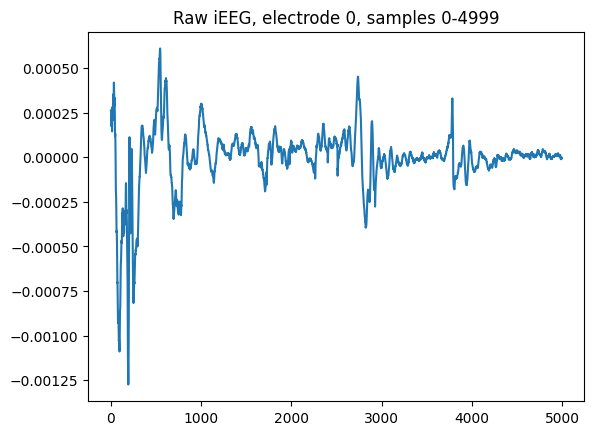

In [12]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

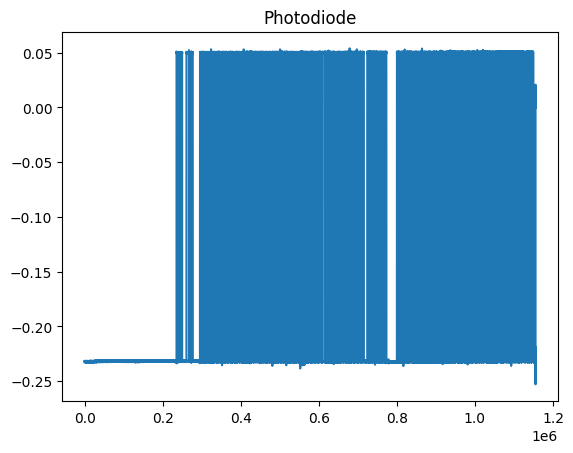

In [13]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [14]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/photodiode.fif
[done]


In [15]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS004_SWB.edf, 147 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

### Anatomical Localization

In [16]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS004_SWB.edf, 147 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

In [17]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0    LaCaS1    Unknown  -4.999780  32.998632   9.399995  -5.110147  20.313460   
1   LaCaS10     A8dl_L -19.799162  40.998299  51.399993 -21.380381  33.493736   
2    LaCaS2    Unknown  -6.999697  33.798599  13.799995  -7.451296  21.880915   
3    LaCaS3    Unknown  -8.599630  34.998549  18.599995  -9.401439  23.748520   
4    LaCaS4     A32p_L -10.199563  36.198499  22.999995 -11.236510  25.502741   
..      ...        ...        ...        ...        ...        ...        ...   
77   RmOlF5    Unknown  25.398950  35.798516  15.799995  28.472357  25.071580   
78   RmOlF6    Unknown  28.998799  35.798516  18.999995  32.166475  25.487460   
79   RmOlF7   A9/46v_R  32.998632  34.998549  21.399995  36.411860  24.897113   
80   RmOlF8     A8vl_R  36.998465  34.998549  24.199995  40.586243  25.242135   
81   RmOlF9     A8vl_R  40.598314  34.598566  26.999994  44.285109  25.171395   

        mni_z       gm                                 NMM     Anat  \
0   10.206352  Unknown              Left Lateral Ventricle  Unknown   
1   54.675622  Unknown     Left SFG superior frontal gyrus  Unknown   
2   14.764700    White          Left Cerebral White Matter  Unknown   
3   19.653786    White          Left Cerebral White Matter  Area 33   
4   24.173401    White  Left ACgG anterior cingulate gyrus  Unknown   
..        ...      ...                                 ...      ...   
77  17.516928    White         Right Cerebral White Matter  Unknown   
78  21.130085    White         Right Cerebral White Matter  Unknown   
79  24.029039     Gray      Right MFG middle frontal gyrus  Unknown   
80  27.382506     Gray      Right MFG middle frontal gyrus  Unknown   
81  30.762863     Gray         Right Cerebral White Matter  Unknown   

                   AnatMacro    BN246                            YBA_1  \
0                    Unknown  Unknown                          Unknown   
1   L Superior Frontal Gyrus    L SFG  Left superior frontal gyrus 4 D   
2                    Unknown  Unknown                          Unknown   
3                    Unknown  Unknown                          Unknown   
4                    Unknown     L CG           Left cingulate gyrus H   
..                       ...      ...                              ...   
77                   Unknown  Unknown                          Unknown   
78    R Middle Frontal Gyrus  Unknown                          Unknown   
79    R IFG (p Triangularis)    R MFG   Right middle frontal gyrus 4 B   
80    R IFG (p Triangularis)    R MFG                          Unknown   
81    R IFG (p Triangularis)    R MFG   Right middle frontal gyrus 4 C   

           ManualExamination Notes  
0     Left cingulate gyrus H   NaN  
1                        OOB   NaN  
2                         WM   NaN  
3                         WM   NaN  
4                         WM   NaN  
..                       ...   ...  
77                        WM   NaN  
78                        WM   NaN  
79                       NaN   NaN  
80  Right middle frontal 4 B   NaN  
81                       NaN   NaN  

[82 rows x 16 columns]

In [18]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'uLmOlF',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'pLesHM1',
 'pLesHM2',
 'pLesHM3',
 'pLesHM4',
 'pLesHM5',
 'pLesHM6',
 'pLesHM7',
 'pLesHM8',
 'RaCaS1',
 'RaCaS10',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RHplT1',
 'RHplT10',
 'RHplT2',
 'RHplT3',
 'RHplT4',
 'RHplT5',
 'RHplT6',
 'RHplT7',
 'RHplT8',
 'RHplT9',
 'RLes21',
 'RLes22',
 'RLes23',
 'RLes24',
 'RLes25',
 'RLes26',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'uRmOlF',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9']

In [19]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['alespm1', 'alespm2', 'alespm3', 'alespm4', 'alespm5', 'alespm6', 'alespm7', 'alespm8', 'lespm1', 'lespm2', 'lespm3', 'lespm4', 'lespm5', 'lespm6', 'lespm7', 'lespm8', 'lespm9', 'lespm10', 'llespm1', 'llespm2', 'llespm3', 'llespm4', 'llespm5', 'llespm6', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', '02', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c126', 'c127', 'c128', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [20]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [21]:
unmatched_seeg #make sure there are no unmatched names


[]

In [22]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [23]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'rmcms1': 'rmcms1',
 'rmcms2': 'rmcms2',
 'rmcms3': 'rmcms3',
 'rmcms4': 'rmcms4',
 'rmcms5': 'rmcms5',
 'rmcms6': 'rmcms6',
 'rmcms7': 'rmcms7',
 'rmcms8': 'rmcms8',
 'alespm1': 'alespm1',
 'alesp

In [24]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS004_SWB.edf, 147 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

In [25]:
# right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
# left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
# print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
# print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



In [26]:
# this subject has ch that start with a or p(ugh)
real_ch = mne_data.ch_names[:104] # 104 confirmed manually 
drop_ch =  mne_data.ch_names[105:]
drop_ch

['f7',
 't3',
 't5',
 'o1',
 'f3',
 'c3',
 'p3',
 'fp2',
 'f8',
 't4',
 't6',
 '02',
 'f4',
 'c4',
 'p4',
 'fz',
 'cz',
 'pz',
 'ekg1',
 'ekg2',
 'c126',
 'c127',
 'c128',
 'dc2',
 'dc3',
 'dc4',
 'dc5',
 'dc6',
 'dc7',
 'dc8',
 'dc9',
 'dc10',
 'dc11',
 'dc12',
 'dc13',
 'dc14',
 'dc15',
 'dc16',
 'trig',
 'osat',
 'pr',
 'pleth']

In [27]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in real_ch}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS004_SWB.edf, 147 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

In [28]:
mne_data.drop_channels(drop_ch) #number of chans should = number of seegs 

<RawEDF | MS004_SWB.edf, 105 x 1155312 (2310.6 s), ~925.6 MB, data loaded>

In [29]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS004_SWB.edf, 105 x 1155312 (2310.6 s), ~925.6 MB, data loaded>

In [30]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [31]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [32]:
probe_ch_counts

{'lacas': 10,
 'lhplt': 10,
 'lmolf': 9,
 'pleshm': 8,
 'racas': 10,
 'rhplt': 10,
 'rles': 6,
 'rmcms': 8,
 'rmolf': 9,
 'ulmolf': 1,
 'urmolf': 1}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [33]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [34]:
# %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=20, scalings=mne_data._data.max()/50)


## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [36]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [7]:
#run if only re-ref
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/raw_ieeg.fif...
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Reading 0 ... 1155311  =      0.000 ...  2310.622 secs...


### Bipolar Re-ref

In [8]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is greater than the number of electrodes in the localization file
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=33, n_times=1155312
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Added the following bipolar channels:
lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lhplt6-lhplt7, lhplt7-lhplt8, lhplt8-lhplt9, lhplt9-lhplt10, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, pleshm1-pleshm2, racas2-racas3, racas3-racas4, racas4-racas5, racas5-racas6, racas8-racas9, rhplt1-rhplt2, rhplt7-rhplt8, rles22-rles23, rles23-rles24, rles24-rles25, rmcms1-rmcms2, rmcms2-rmcms3, rmcms3-rmcms4, rmcms4-rmcms5, rmolf3-rmolf4, rmolf6-rmolf7, rmolf7-rmolf8, rmolf8-rmolf9


In [9]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 33 x 1155312 (2310.6 s), ~290.9 MB, data loaded>

In [10]:
mne_data_bp_reref.ch_names

['lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt6-lhplt7',
 'lhplt7-lhplt8',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'pleshm1-pleshm2',
 'racas2-racas3',
 'racas3-racas4',
 'racas4-racas5',
 'racas5-racas6',
 'racas8-racas9',
 'rhplt1-rhplt2',
 'rhplt7-rhplt8',
 'rles22-rles23',
 'rles23-rles24',
 'rles24-rles25',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms4-rmcms5',
 'rmolf3-rmolf4',
 'rmolf6-rmolf7',
 'rmolf7-rmolf8',
 'rmolf8-rmolf9']

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

<IPython.core.display.Javascript object>


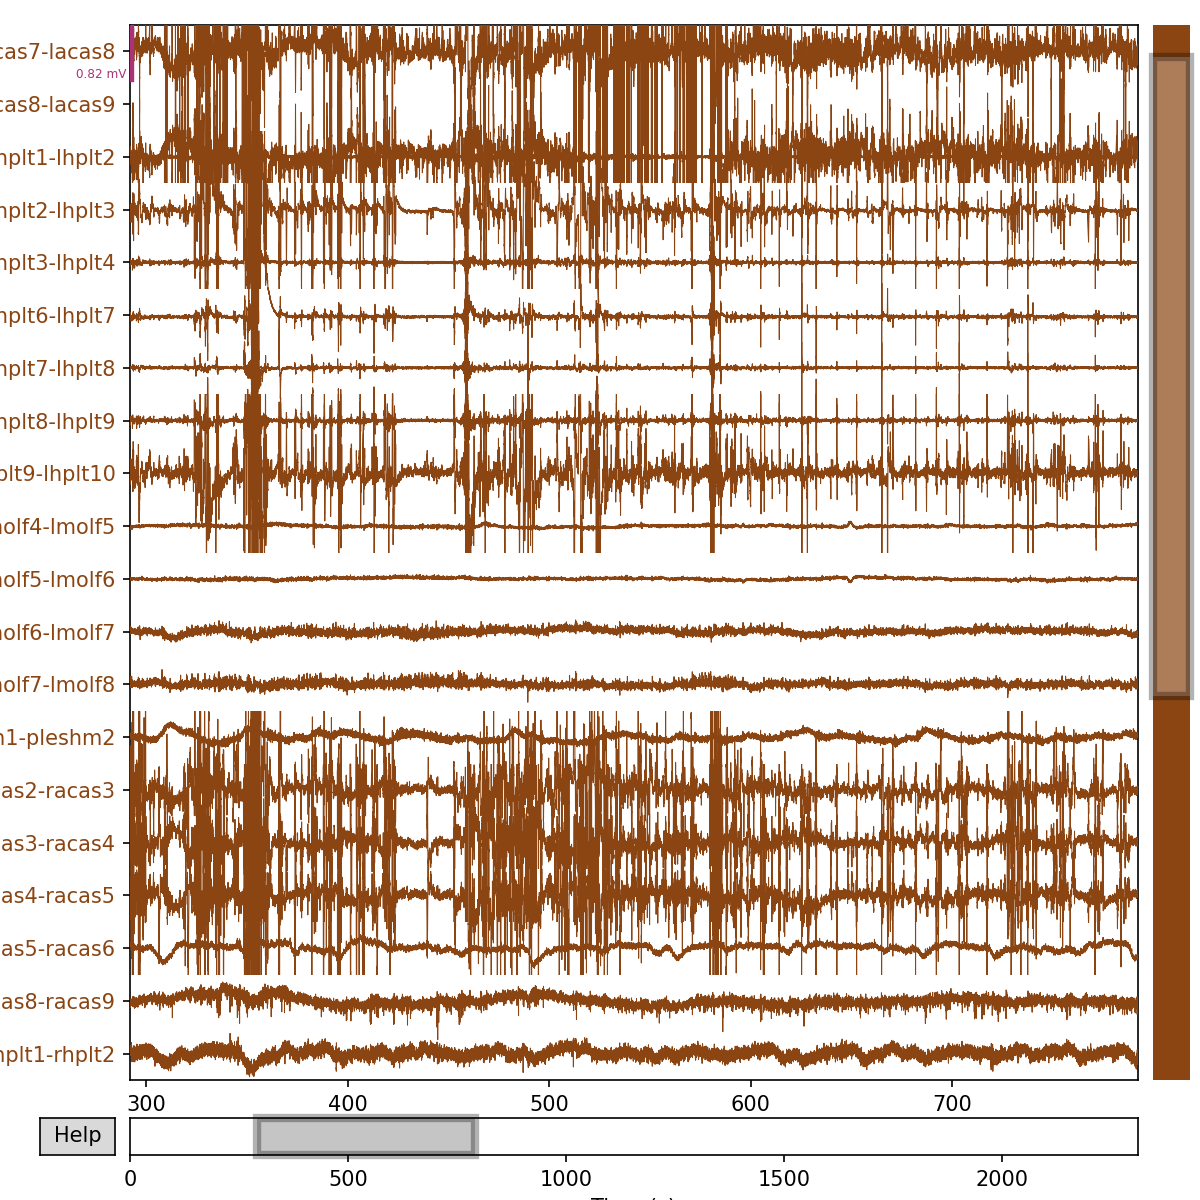

In [13]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/50)
# fig.fake_keypress('a')

Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


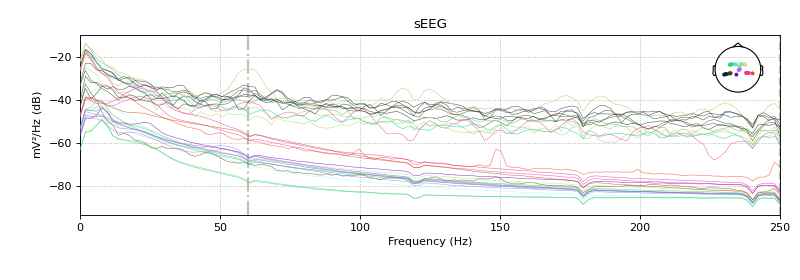

<IPython.core.display.Javascript object>


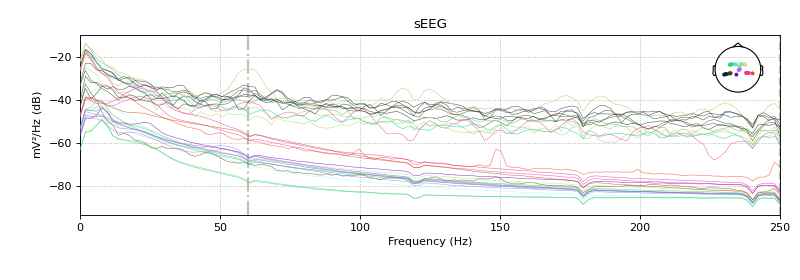

In [47]:
mne_data_bp_reref.compute_psd().plot()

#### idea for salman - threshold offset above X + signal variance? ie constant squiggles 

In [48]:
print(mne_data_bp_reref.info['bads'],date)

['lacas8-lacas9'] 05132024


## Save Reref Data

In [49]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif
[done]


In [50]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [51]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1       64.0      gain   594.818786   594.830406     598.729857   
1        2      136.0      loss   605.387332   605.395078     608.326181   
2        3      102.0      loss   615.182929   615.183646     617.804095   
3        4        6.0       mix   629.837833   629.845519     636.012435   
4        5       17.0       mix   643.224913   643.225653     646.292064   
..     ...        ...       ...          ...          ...            ...   
146    147       54.0      gain  2250.992145  2250.992922    2252.214449   
147    148      148.0      loss  2265.135985  2265.136707    2268.508553   
148    149       68.0      gain  2275.581040  2275.581750    2277.620345   
149    150        9.0       mix  2283.710522  2283.711232    2286.365219   
150    151       34.0       mix  2294.672682  2294.673395    2296.744626   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0       600.756093  3.899451      0.3    0.00  ...      0.67        0.37   
1       610.340633  2.931103     -0.5   -1.40  ...     -1.40       -0.90   
2       619.830932  2.620450     -0.2   -0.36  ...      0.36        0.20   
3       638.023989  6.166916      0.0   -0.30  ...     -0.55       -0.30   
4       648.302583  3.066411      0.0   -0.80  ...     -1.12       -0.80   
..             ...       ...      ...     ...  ...       ...         ...   
146    2254.240715  1.221527      0.2    0.00  ...      0.44        0.24   
147    2268.515706  3.371846     -0.6   -2.16  ...      1.56        1.56   
148    2279.639262  2.038596      0.3    0.00  ...      1.08        0.78   
149    2286.372468  2.653987      0.0   -0.50  ...     -0.15       -0.15   
150    2296.748275  2.071231      0.0   -1.50  ...     -1.50       -1.50   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0          0.00           0.00        0.67           0.37     0.00   
1         -1.40          -0.90        0.00           0.00     0.00   
2          0.00           0.00        0.36           0.20    -0.36   
3         -0.55          -0.30        0.00           0.00     0.25   
4         -1.12          -0.80        0.00           0.00     0.32   
..          ...            ...         ...            ...      ...   
146        0.00           0.00        0.44           0.24     0.00   
147        0.00           0.00        1.56           1.56    -2.16   
148        0.00           0.00        1.08           0.78     0.00   
149       -0.15          -0.15        0.00           0.00     0.15   
150       -1.50          -1.50        0.00           0.00     1.50   

     decisionCF   pRPE   nRPE  
0          0.30  0.335  0.000  
1         -0.50  0.000 -0.700  
2         -0.20  0.180  0.000  
3          0.00  0.000 -0.275  
4          0.00  0.000 -0.560  
..          ...    ...    ...  
146        0.20  0.220  0.000  
147       -2.16  0.000  0.000  
148        0.30  0.540  0.000  
149        0.15  0.000  0.000  
150        1.50  0.000  0.000  

[151 rows x 32 columns]

In [55]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/photodiode.fif...
Isotrak not found
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Reading 0 ... 1155311  =      0.000 ...  2310.622 secs...


In [56]:
photodiode_data

<Raw | photodiode.fif, 1 x 1155312 (2310.6 s), ~8.8 MB, data loaded>

<IPython.core.display.Javascript object>


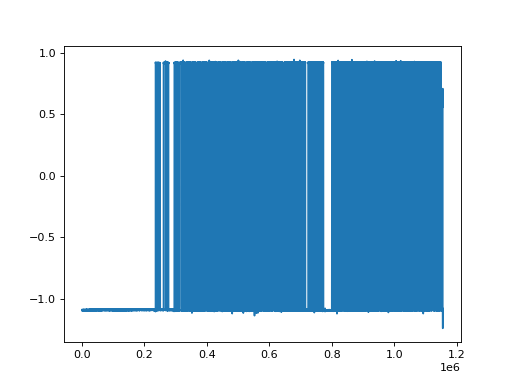

In [60]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.show()


In [68]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 157 pulses


In [69]:
print(slope, offset,smoothSize,windSize,height)

0.9999917699032468 -4.043263779094104 11 15 0.7


In [70]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

151

In [71]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


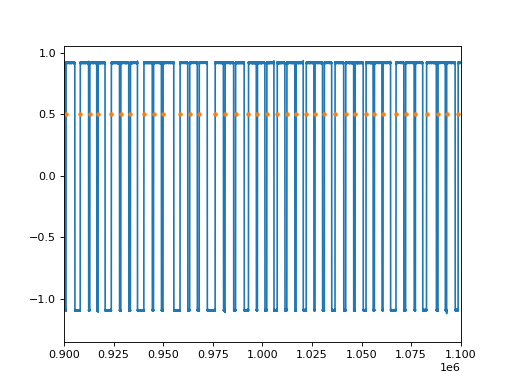

In [76]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([900000,1100000])
plt.show()

# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [77]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1       64.0      gain   594.818786   594.830406     598.729857   
1        2      136.0      loss   605.387332   605.395078     608.326181   
2        3      102.0      loss   615.182929   615.183646     617.804095   
3        4        6.0       mix   629.837833   629.845519     636.012435   
4        5       17.0       mix   643.224913   643.225653     646.292064   
..     ...        ...       ...          ...          ...            ...   
146    147       54.0      gain  2250.992145  2250.992922    2252.214449   
147    148      148.0      loss  2265.135985  2265.136707    2268.508553   
148    149       68.0      gain  2275.581040  2275.581750    2277.620345   
149    150        9.0       mix  2283.710522  2283.711232    2286.365219   
150    151       34.0       mix  2294.672682  2294.673395    2296.744626   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0       600.756093  3.899451      0.3    0.00  ...      0.67        0.37   
1       610.340633  2.931103     -0.5   -1.40  ...     -1.40       -0.90   
2       619.830932  2.620450     -0.2   -0.36  ...      0.36        0.20   
3       638.023989  6.166916      0.0   -0.30  ...     -0.55       -0.30   
4       648.302583  3.066411      0.0   -0.80  ...     -1.12       -0.80   
..             ...       ...      ...     ...  ...       ...         ...   
146    2254.240715  1.221527      0.2    0.00  ...      0.44        0.24   
147    2268.515706  3.371846     -0.6   -2.16  ...      1.56        1.56   
148    2279.639262  2.038596      0.3    0.00  ...      1.08        0.78   
149    2286.372468  2.653987      0.0   -0.50  ...     -0.15       -0.15   
150    2296.748275  2.071231      0.0   -1.50  ...     -1.50       -1.50   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0          0.00           0.00        0.67           0.37     0.00   
1         -1.40          -0.90        0.00           0.00     0.00   
2          0.00           0.00        0.36           0.20    -0.36   
3         -0.55          -0.30        0.00           0.00     0.25   
4         -1.12          -0.80        0.00           0.00     0.32   
..          ...            ...         ...            ...      ...   
146        0.00           0.00        0.44           0.24     0.00   
147        0.00           0.00        1.56           1.56    -2.16   
148        0.00           0.00        1.08           0.78     0.00   
149       -0.15          -0.15        0.00           0.00     0.15   
150       -1.50          -1.50        0.00           0.00     1.50   

     decisionCF   pRPE   nRPE  
0          0.30  0.335  0.000  
1         -0.50  0.000 -0.700  
2         -0.20  0.180  0.000  
3          0.00  0.000 -0.275  
4          0.00  0.000 -0.560  
..          ...    ...    ...  
146        0.20  0.220  0.000  
147       -2.16  0.000  0.000  
148        0.30  0.540  0.000  
149        0.15  0.000  0.000  
150        1.50  0.000  0.000  

[151 rows x 32 columns]

In [78]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('gamble', 598.7298568999977, 600.7560934000066),
 ('gamble', 608.3261809000105, 610.3406330000143),
 ('gamble', 617.8040954000026, 619.8309321000124),
 ('gamble', 636.0124348000099, 638.0239893000107),
 ('gamble', 646.2920641000092, 648.3025826000085),
 ('safe', 656.0880514000019, 656.0952131999948),
 ('safe', 674.1798198999895, 674.187230600015),
 ('safe', 685.4576235999994, 685.4648762000143),
 ('safe', 695.7682150999899, 695.7722957000078),
 ('gamble', 710.7791753000056, 712.7932369000046),
 ('gamble', 720.8266382000002, 722.8419905999908),
 ('gamble', 729.6201689000009, 731.630218700011),
 ('gamble', 745.3136869000155, 747.32964489999),
 ('gamble', 754.0761708999926, 756.096105500008),
 ('gamble', 763.9736144999915, 765.9937153999927),
 ('gamble', 778.1329523999884, 780.1493192999915),
 ('gamble', 790.826250699989, 792.8361093999993),
 ('safe', 799.8887772999879, 799.8960733000131),
 ('safe', 813.3988072999928, 813.4067654999963),
 ('gamble', 821.3784696999937, 823.3952980999893)

In [79]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       600.729857
1       610.326181
2       619.804095
3       638.012435
4       648.292064
          ...     
146    2254.214449
147    2270.508553
148    2279.620345
149    2288.365219
150    2298.744626
Name: CpeOnset, Length: 151, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [80]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [81]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [82]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [83]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif...
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Reading 0 ... 1155311  =      0.000 ...  2310.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.6s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif...
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Reading 0 ... 1155311  =      0.000 ...  2310.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.6s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif...
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Reading 0 ... 1155311  =      0.000 ...  2310.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.3s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 2501 original time points ...
0 bad epochs dropped


In [84]:
epochs_all_evs 


{'TrialOnset': <Epochs |  151 events (all good), -2 - 1 sec, baseline off, ~57.1 MB, data loaded,
  'TrialOnset': 151>,
 'DecisionOnset': <Epochs |  151 events (all good), -1.5 - 1 sec, baseline off, ~47.6 MB, data loaded,
  'DecisionOnset': 151>,
 'CpeOnset': <Epochs |  151 events (all good), -1 - 4 sec, baseline off, ~95.2 MB, data loaded,
  'CpeOnset': 151>}

In [134]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [85]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [86]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [87]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

In [88]:
epochs_all_evs

{'TrialOnset': <Epochs |  151 events (all good), -2 - 1 sec, baseline off, ~57.1 MB, data loaded, with metadata,
  'TrialOnset': 151>,
 'DecisionOnset': <Epochs |  151 events (all good), -1.5 - 1 sec, baseline off, ~47.6 MB, data loaded, with metadata,
  'DecisionOnset': 151>,
 'CpeOnset': <Epochs |  151 events (all good), -1 - 4 sec, baseline off, ~95.2 MB, data loaded, with metadata,
  'CpeOnset': 151>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [89]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [90]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [91]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    6.7s finished


Adding metadata with 19 columns


In [92]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 151, channels : 32, ~554.2 MB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [93]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   12.5s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   20.4s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
Not setting metadata
Adding metadata with 19 columns


In [94]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 151, channels : 32, ~277.7 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 151, channels : 32, ~1.62 GB>}

In [95]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 151, channels : 32, ~277.7 MB>

In [96]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 151, channels : 32, ~1.62 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [97]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05132024 -4.043263779094104


Plot TFR for epoch:  DecisionOnset


<IPython.core.display.Javascript object>


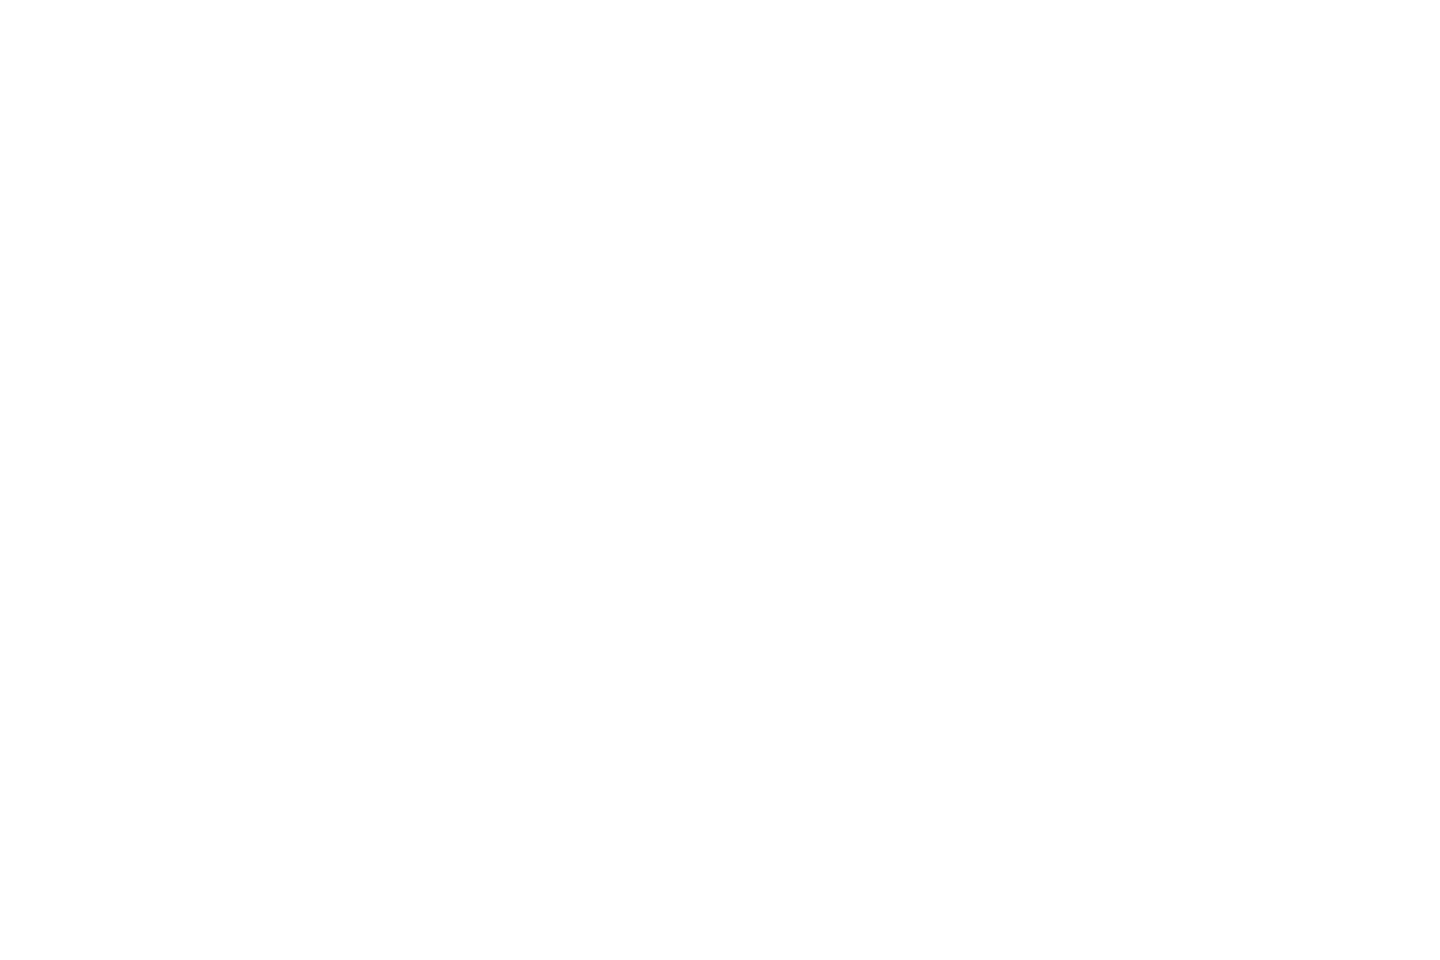

<IPython.core.display.Javascript object>


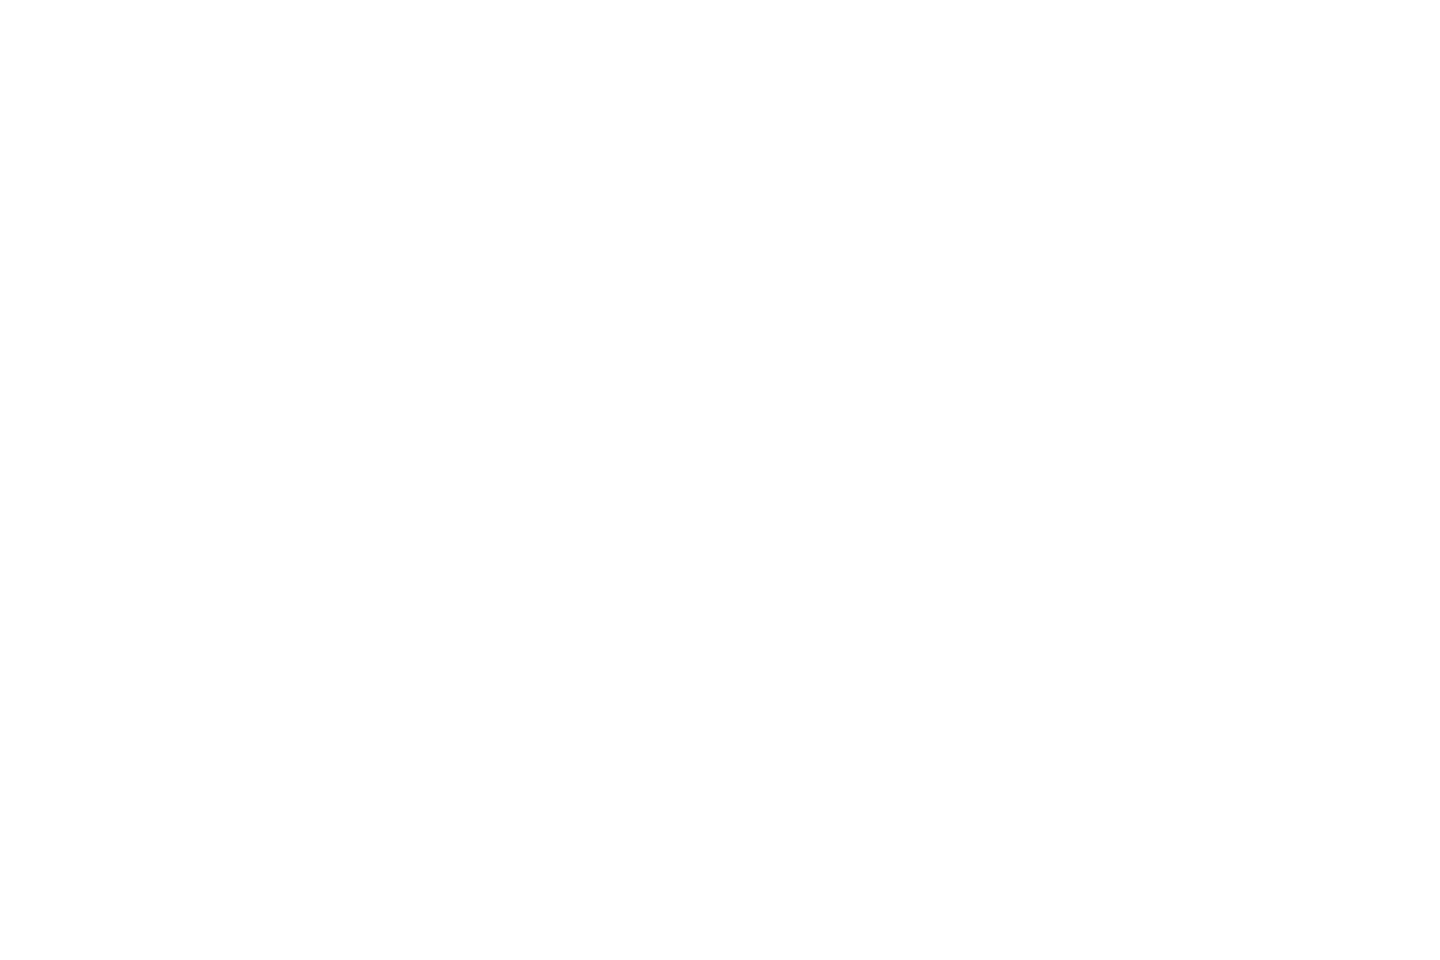

<IPython.core.display.Javascript object>


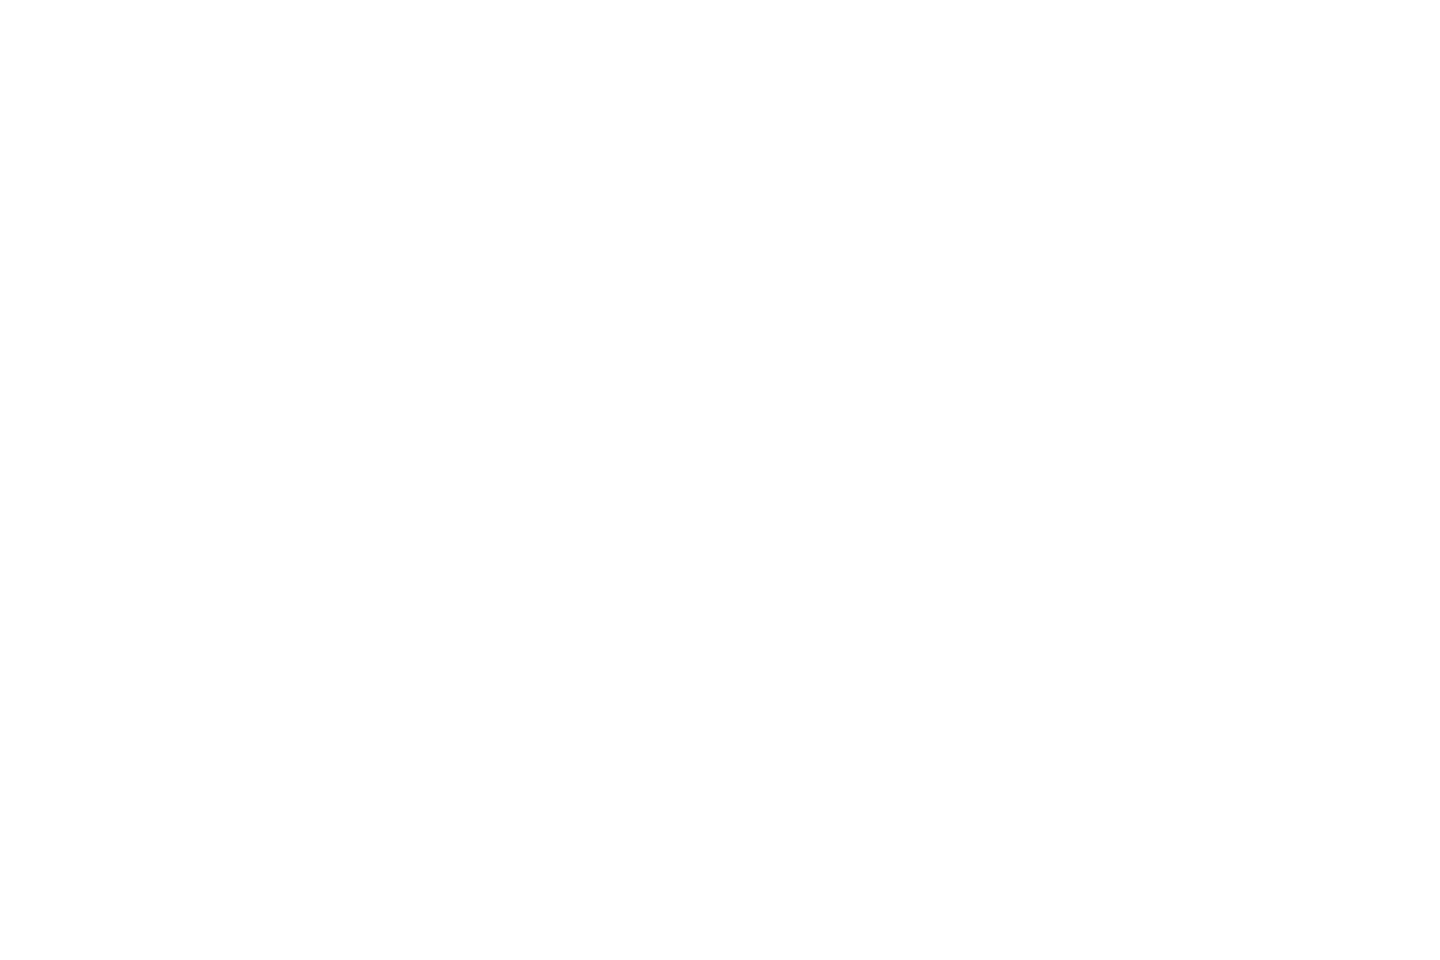

<IPython.core.display.Javascript object>


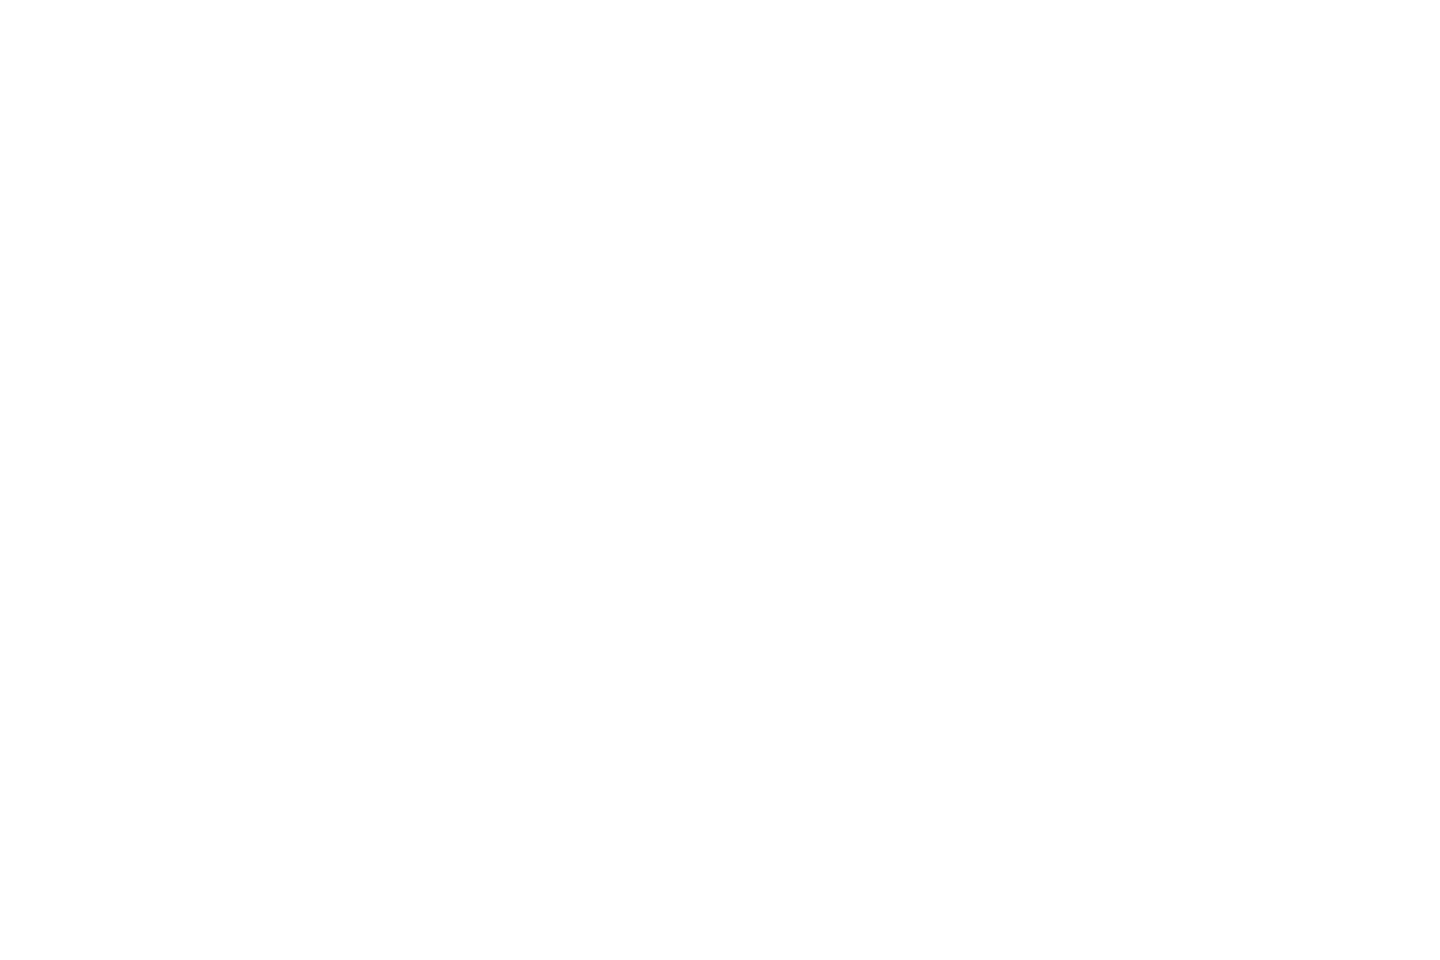

<IPython.core.display.Javascript object>


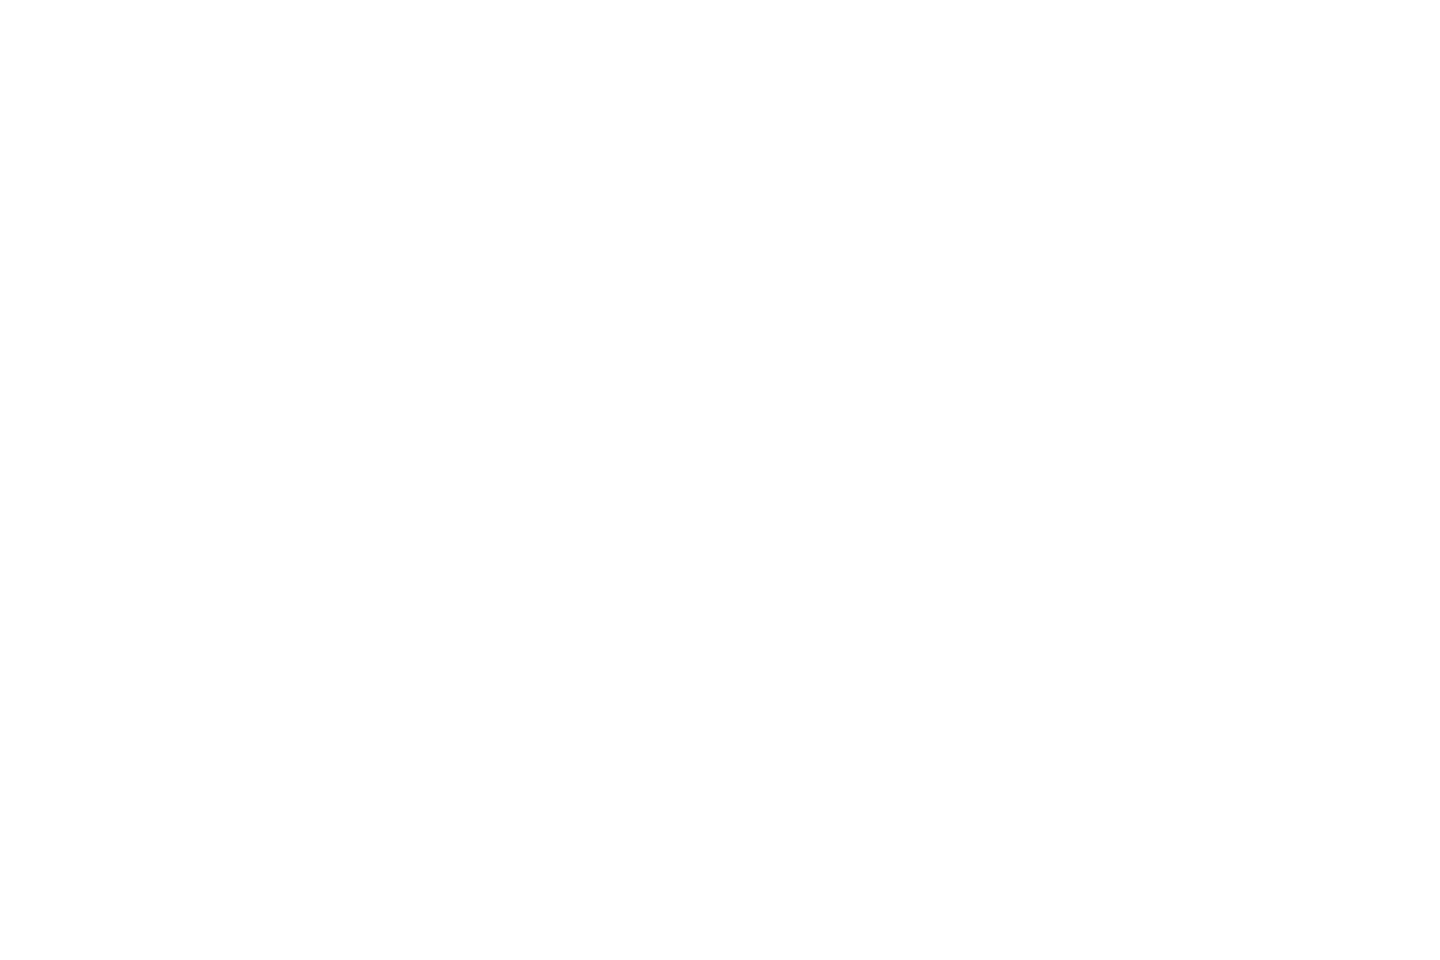

<IPython.core.display.Javascript object>


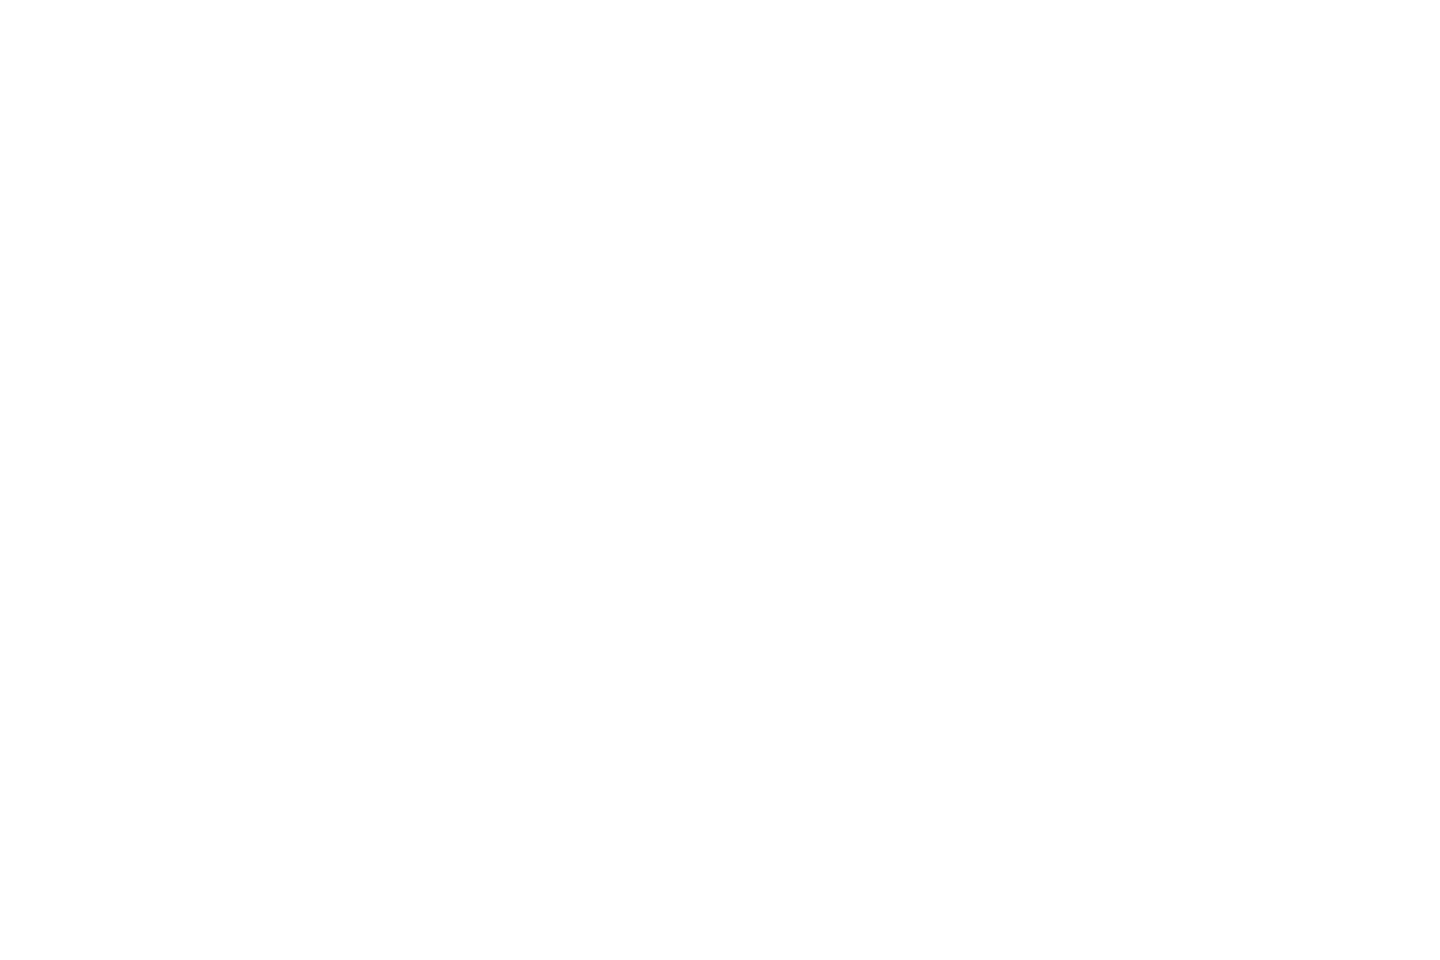

<IPython.core.display.Javascript object>


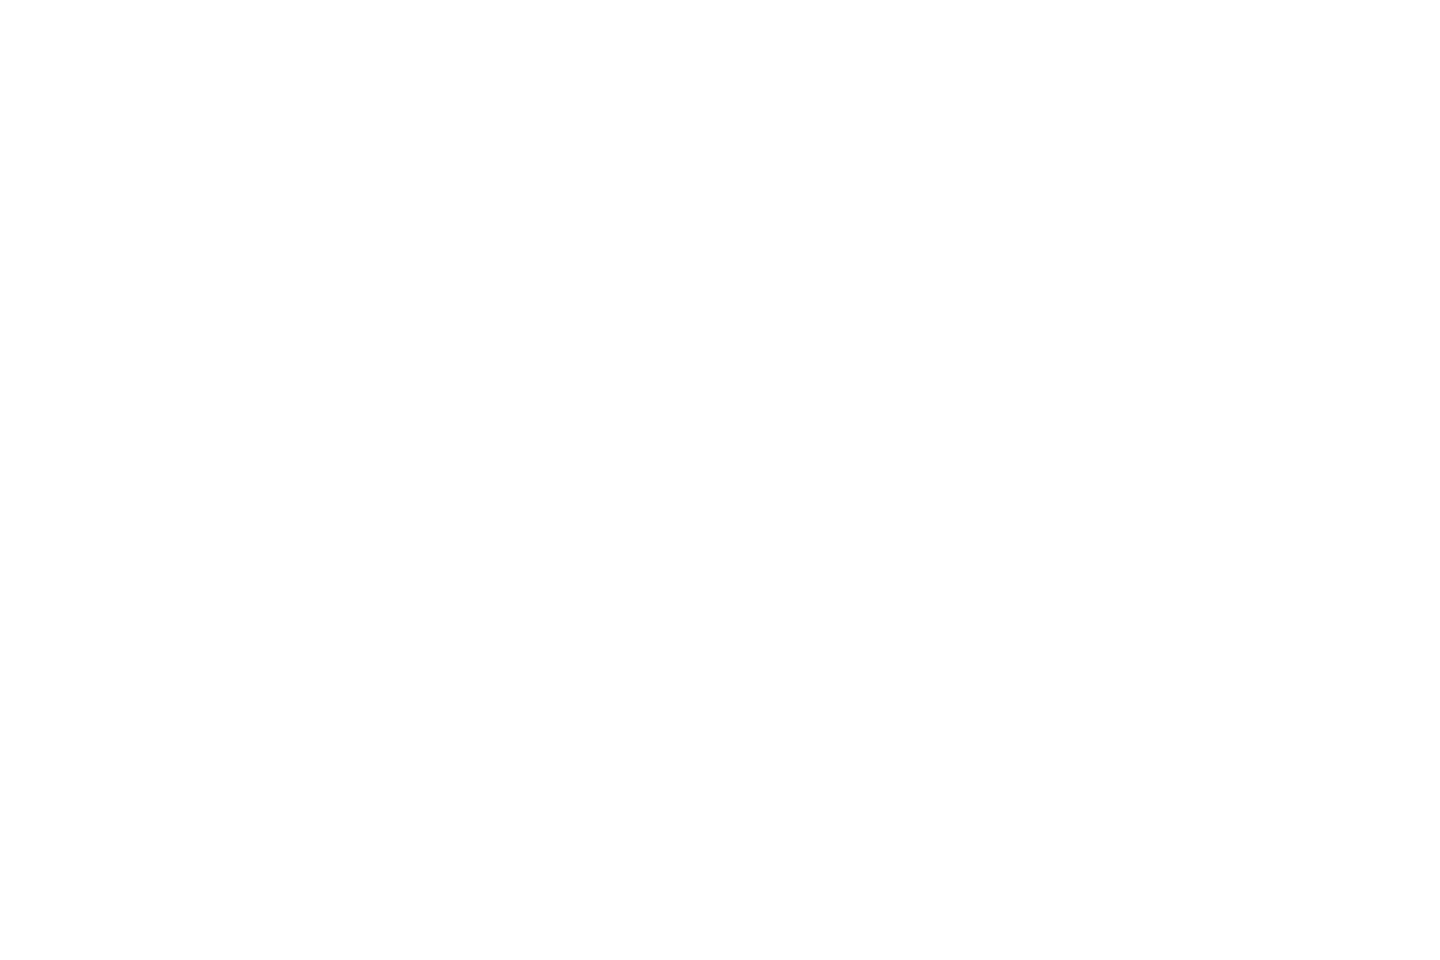

<IPython.core.display.Javascript object>


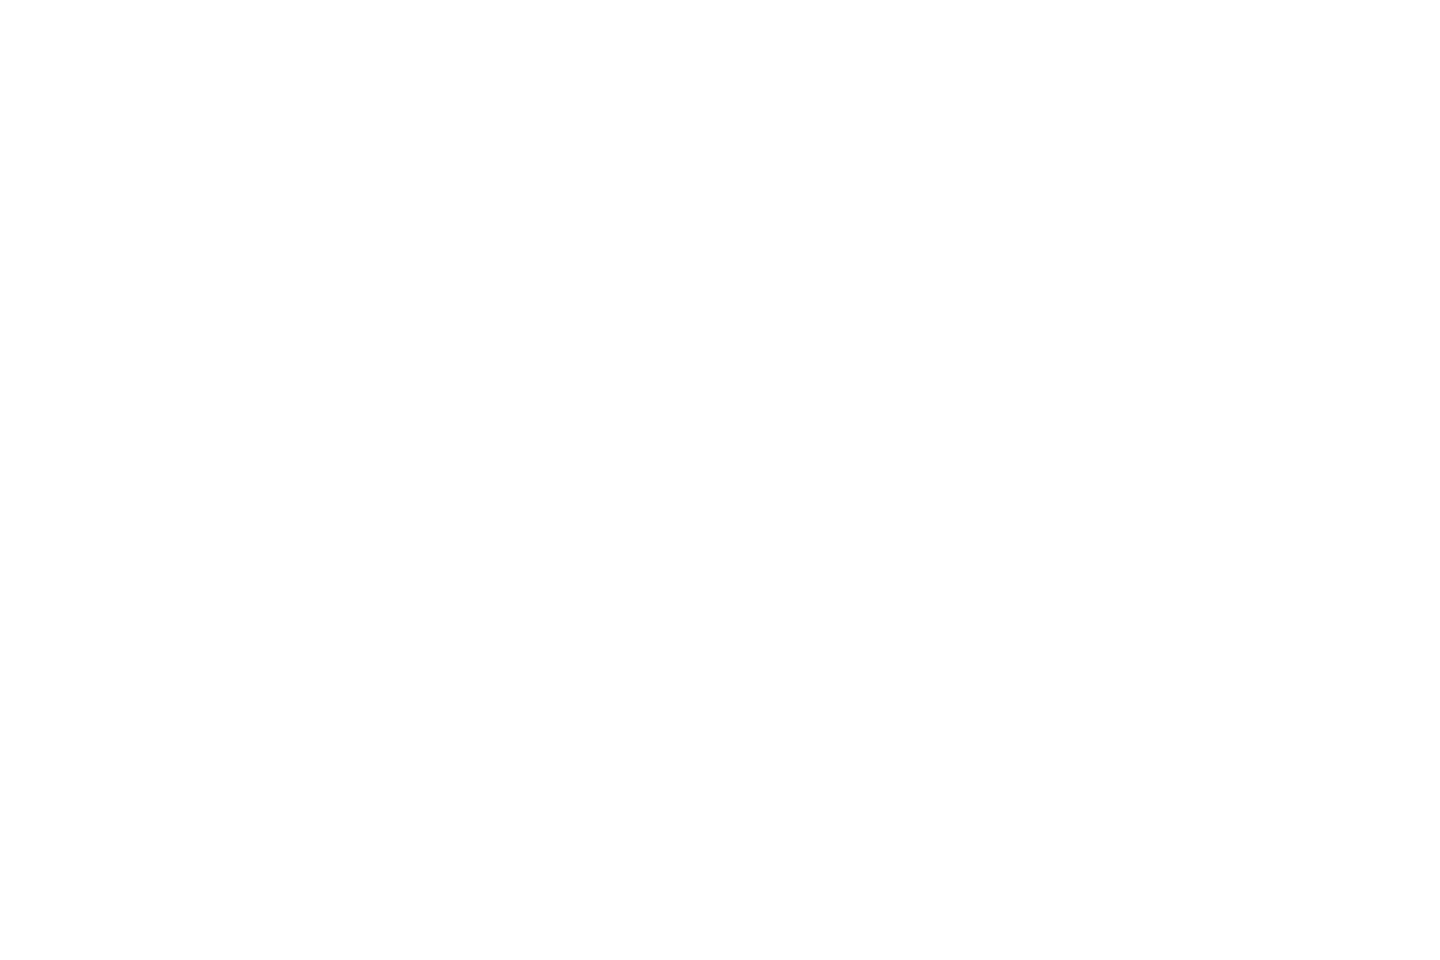

<IPython.core.display.Javascript object>


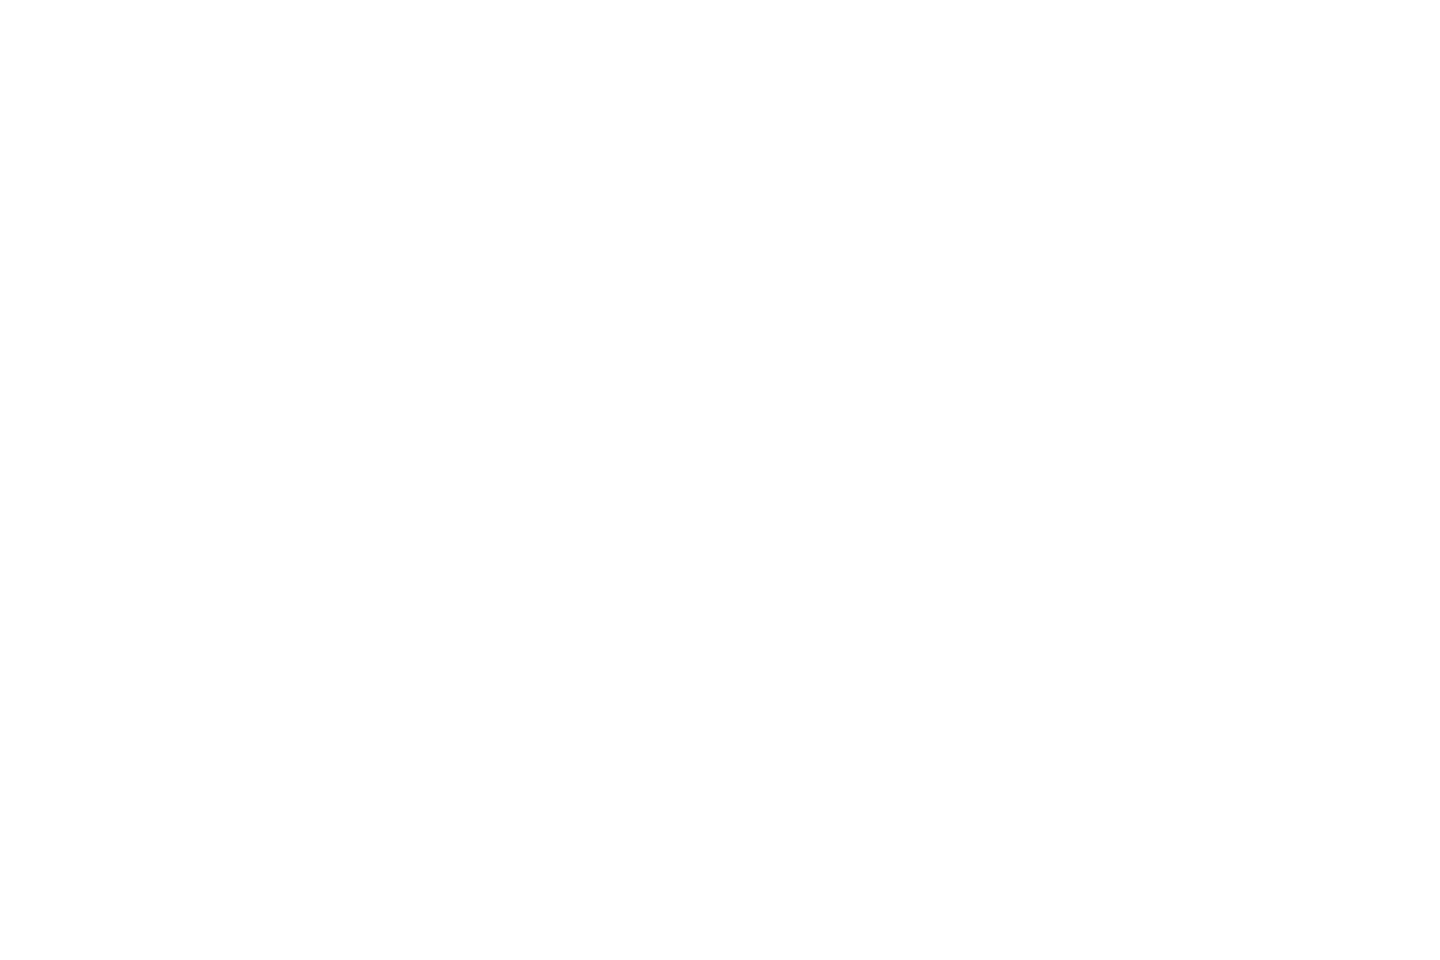

<IPython.core.display.Javascript object>


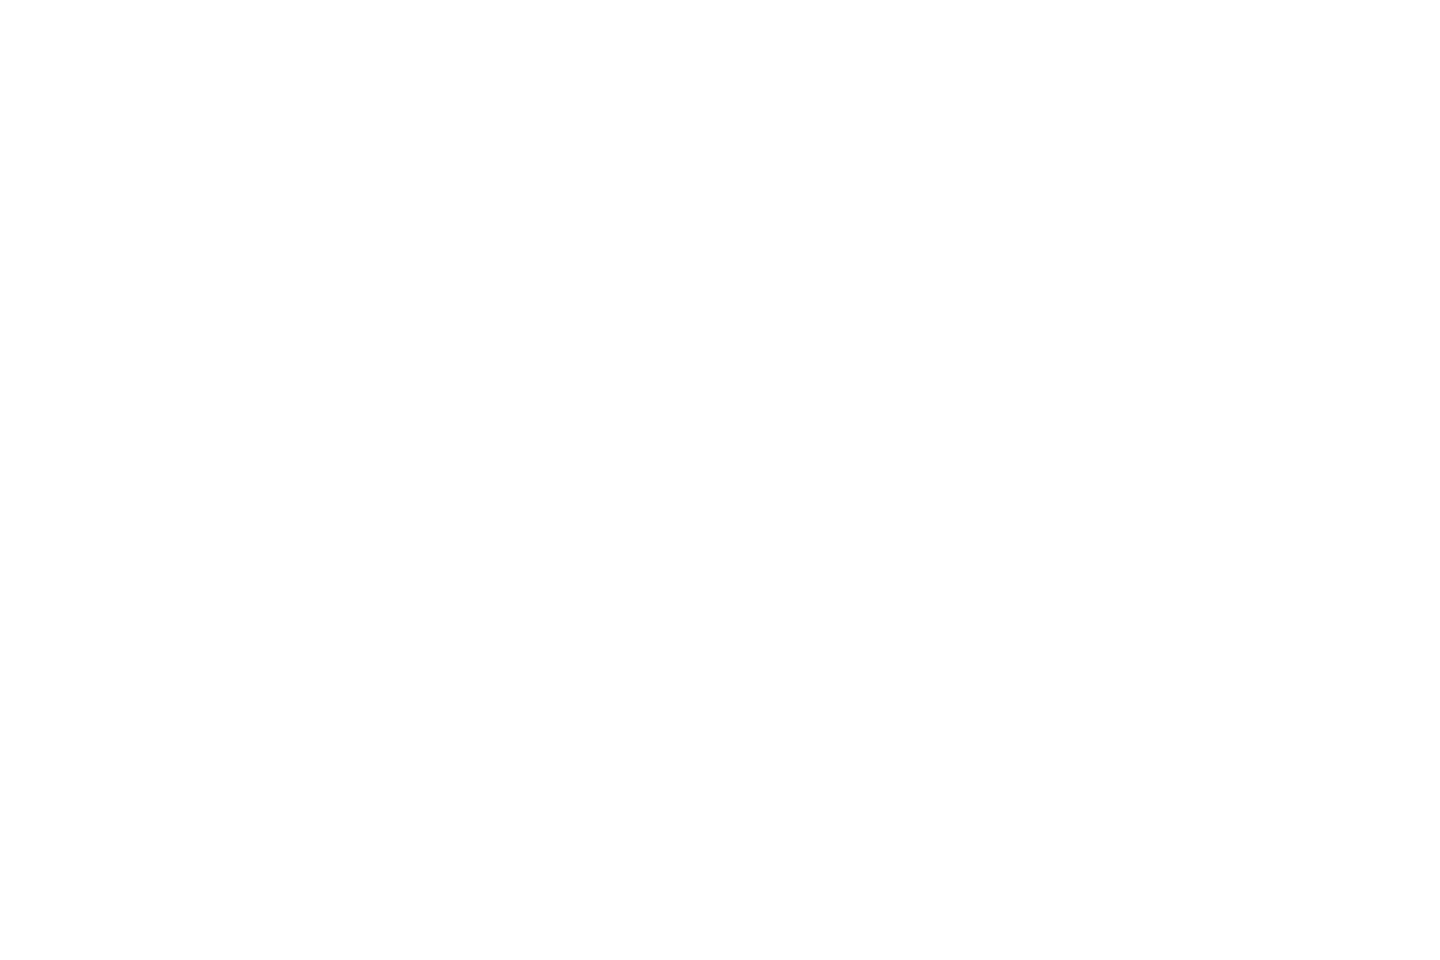

<IPython.core.display.Javascript object>


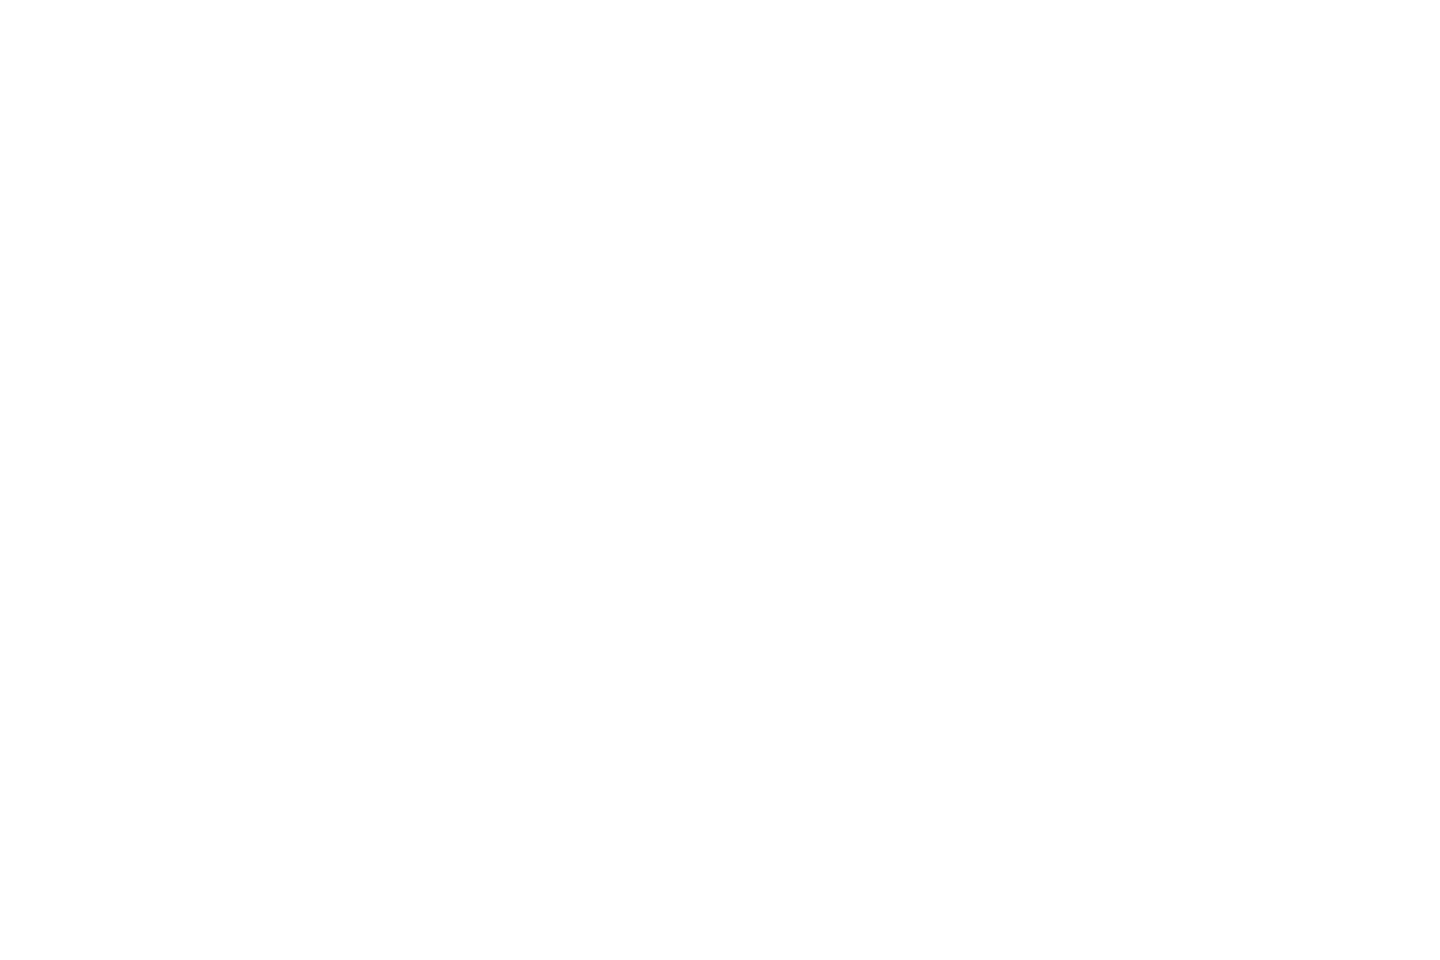

<IPython.core.display.Javascript object>


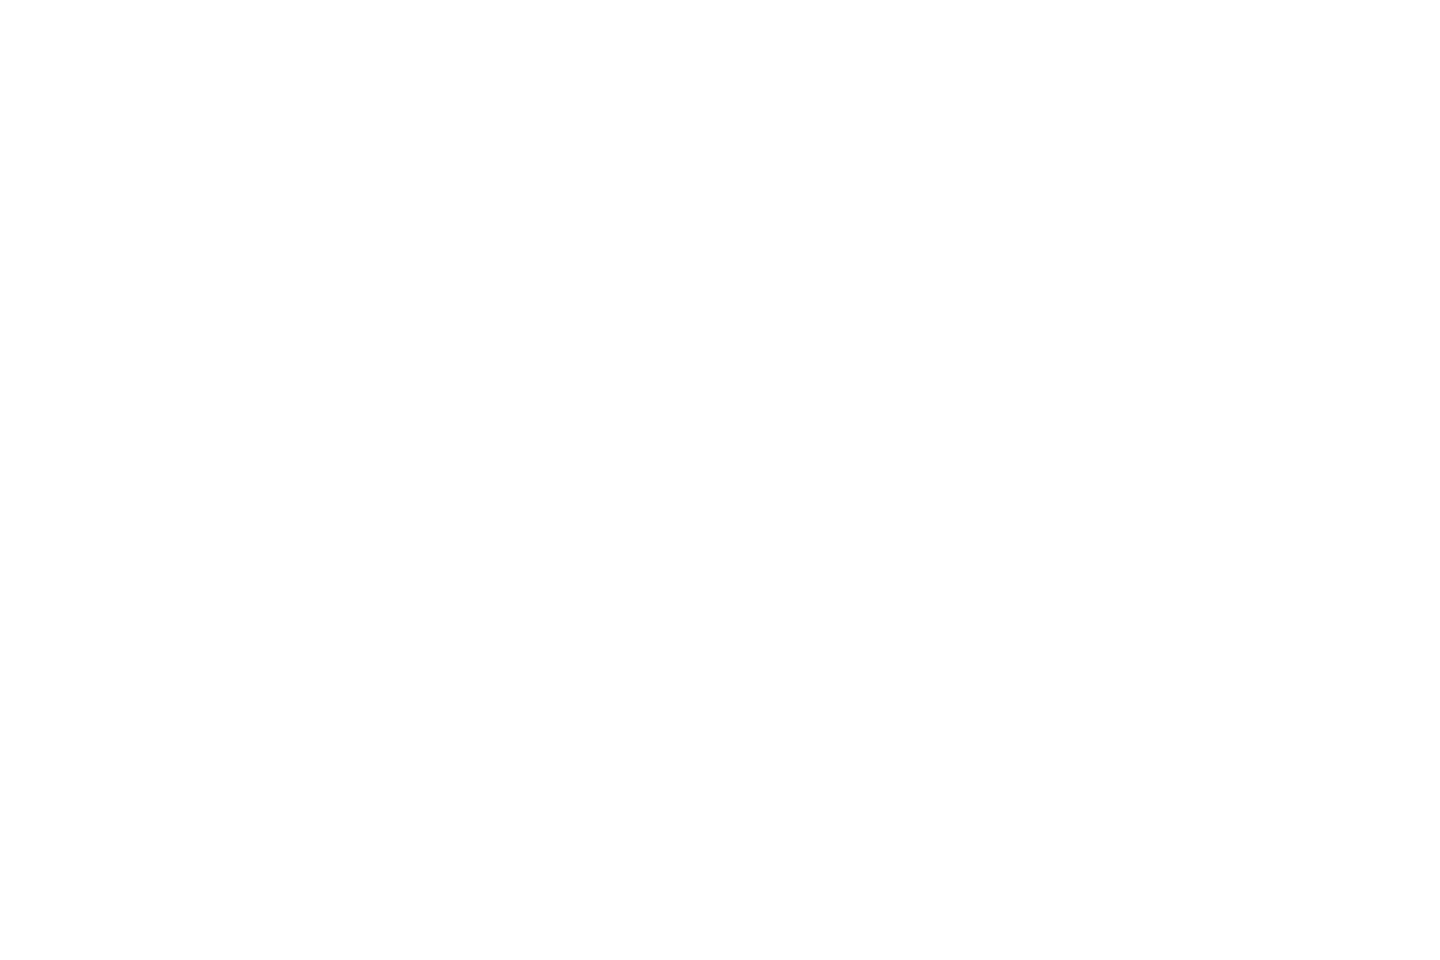

<IPython.core.display.Javascript object>


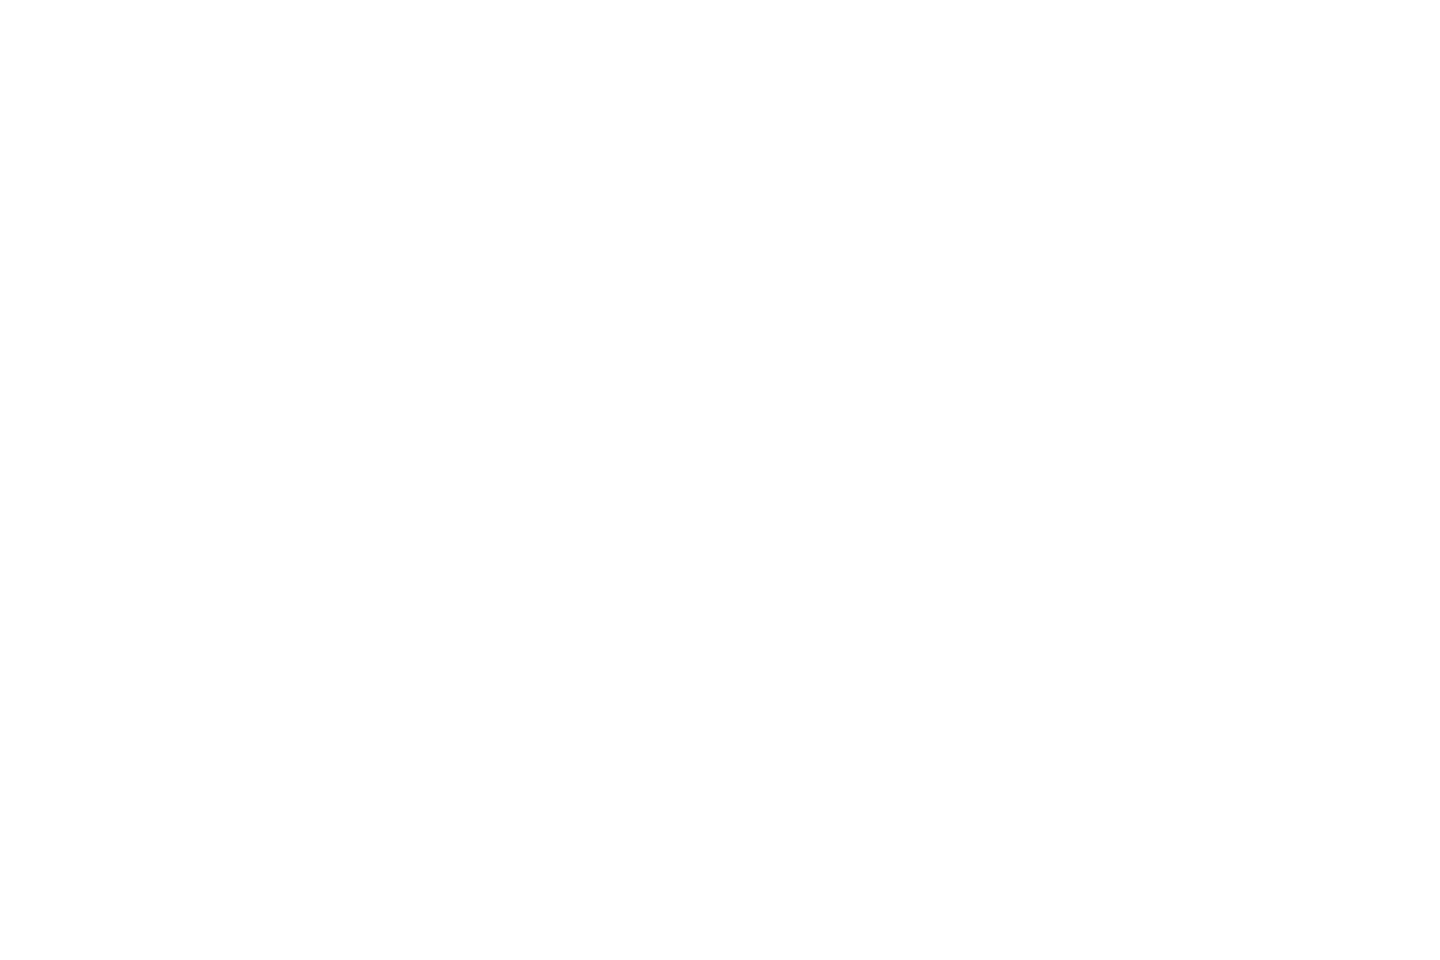

<IPython.core.display.Javascript object>


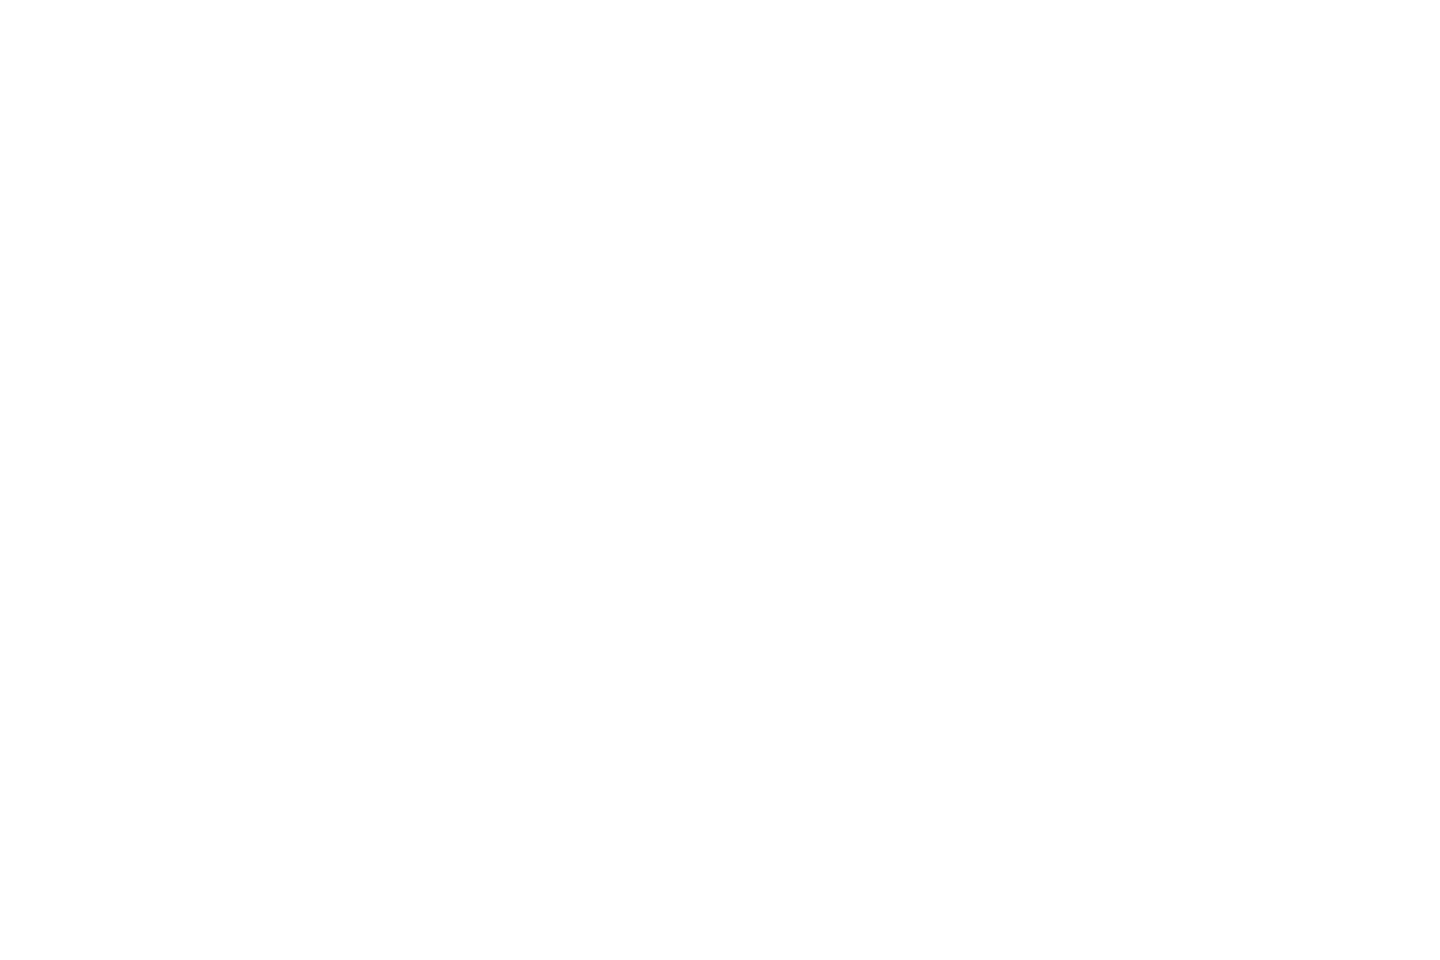

<IPython.core.display.Javascript object>


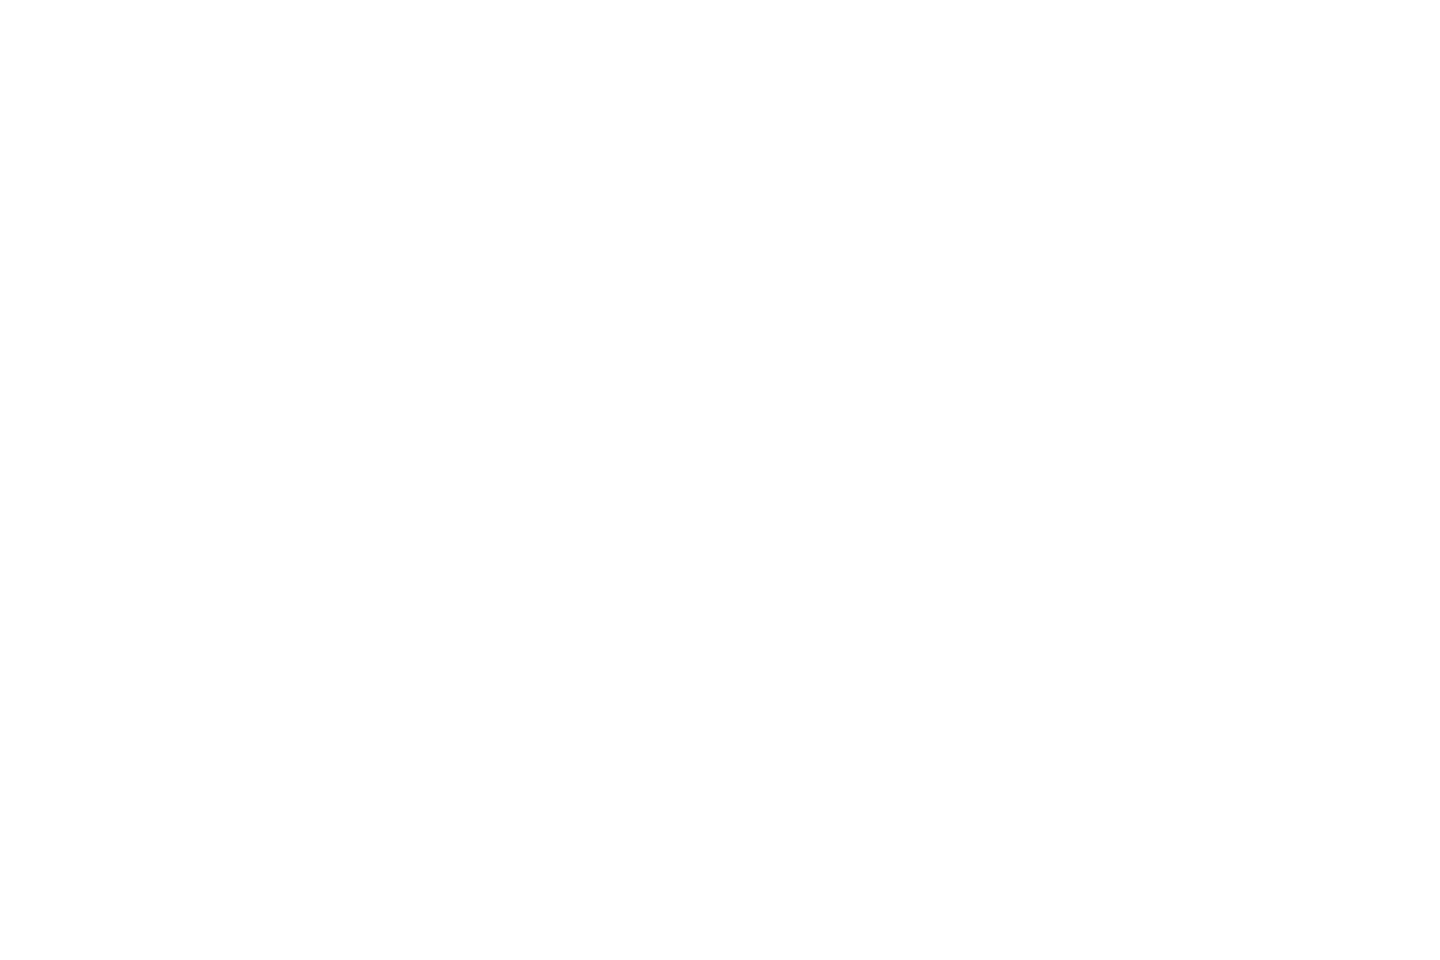

<IPython.core.display.Javascript object>


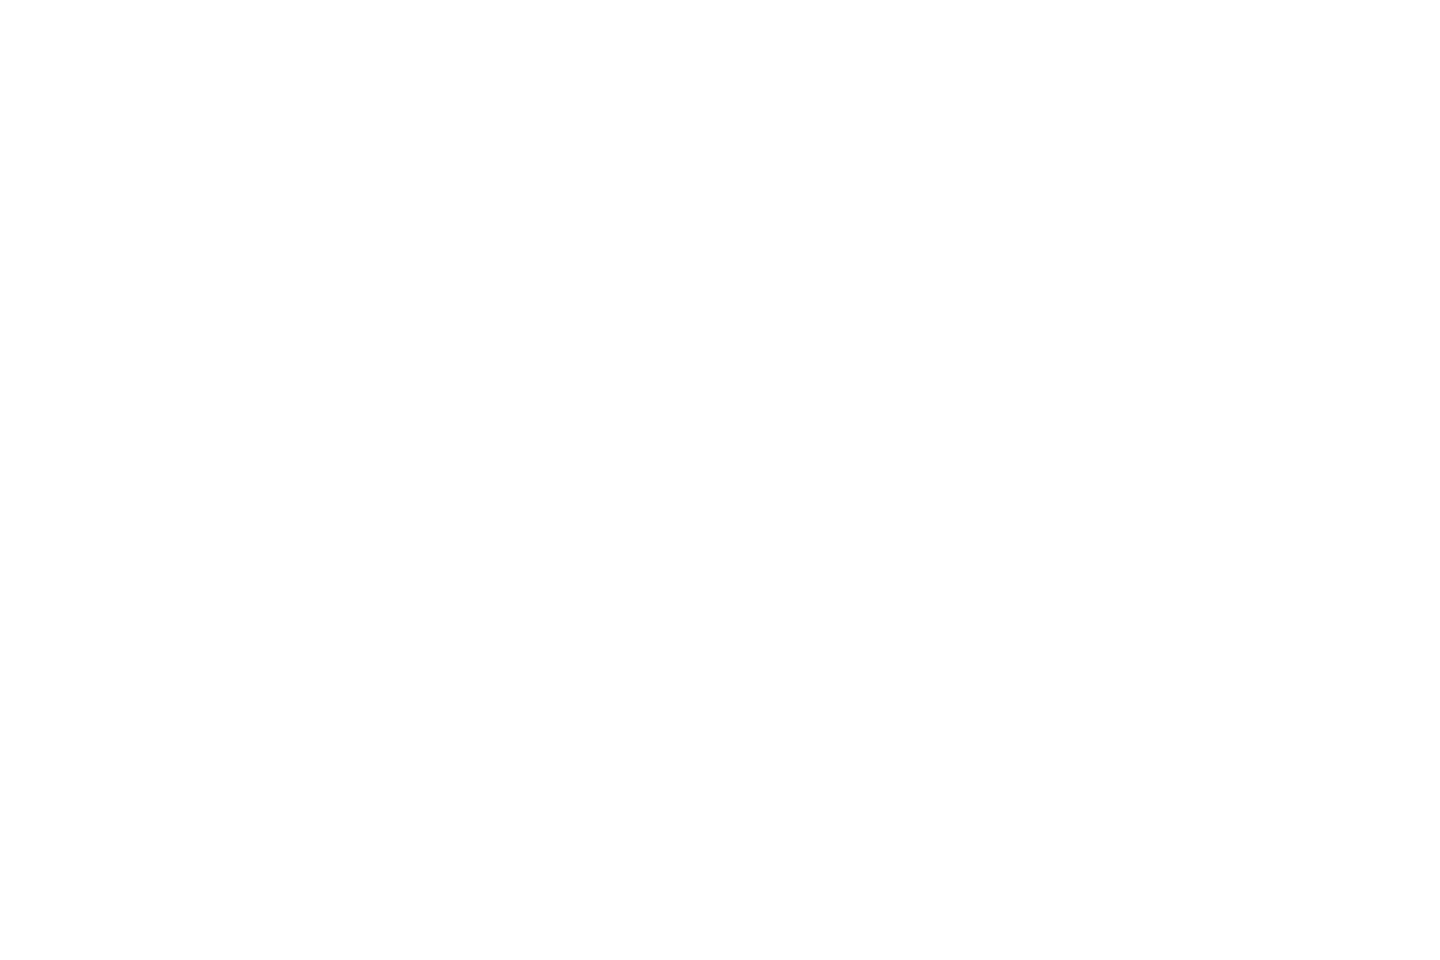

<IPython.core.display.Javascript object>


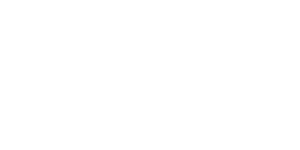

<IPython.core.display.Javascript object>


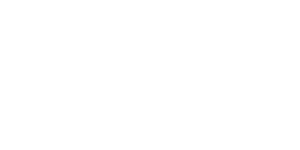

<IPython.core.display.Javascript object>


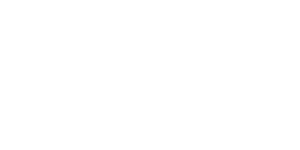

<IPython.core.display.Javascript object>


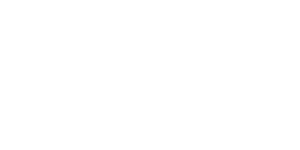

<IPython.core.display.Javascript object>


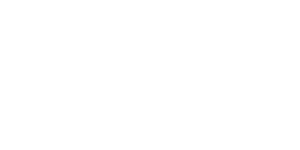

<IPython.core.display.Javascript object>


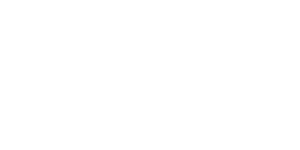

<IPython.core.display.Javascript object>


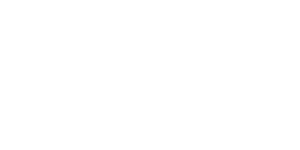

<IPython.core.display.Javascript object>


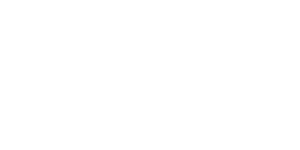

<IPython.core.display.Javascript object>


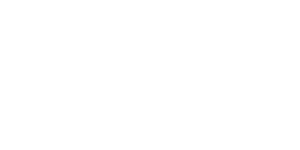

<IPython.core.display.Javascript object>


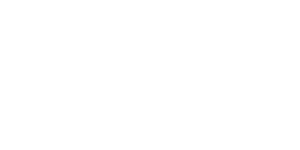

<IPython.core.display.Javascript object>


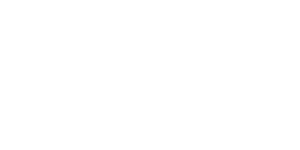

<IPython.core.display.Javascript object>


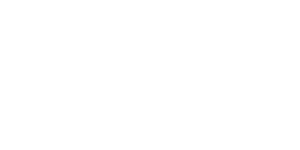

<IPython.core.display.Javascript object>


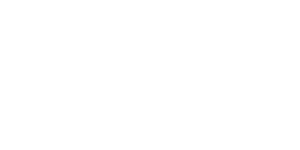

<IPython.core.display.Javascript object>


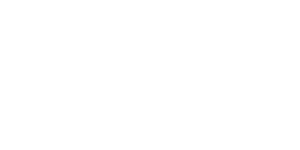

<IPython.core.display.Javascript object>


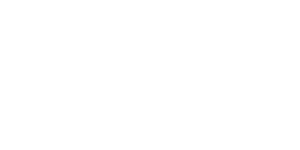

<IPython.core.display.Javascript object>


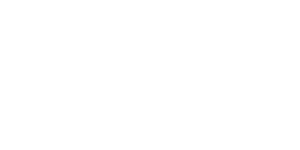

Plot TFR for epoch:  CpeOnset


<IPython.core.display.Javascript object>


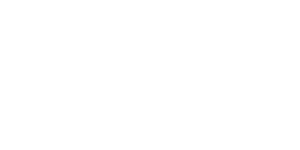

<IPython.core.display.Javascript object>


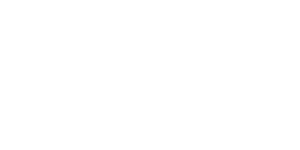

<IPython.core.display.Javascript object>


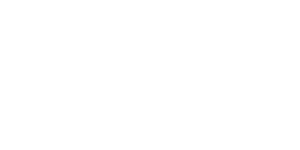

<IPython.core.display.Javascript object>


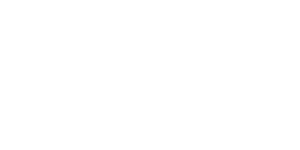

<IPython.core.display.Javascript object>


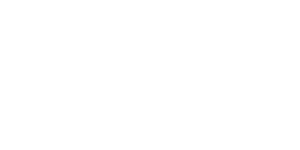

<IPython.core.display.Javascript object>


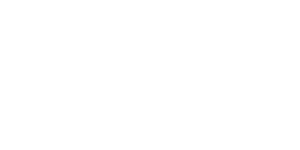

<IPython.core.display.Javascript object>


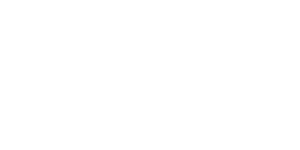

<IPython.core.display.Javascript object>


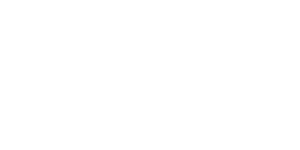

<IPython.core.display.Javascript object>


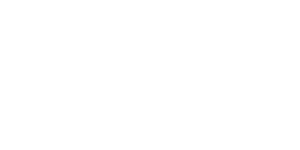

<IPython.core.display.Javascript object>


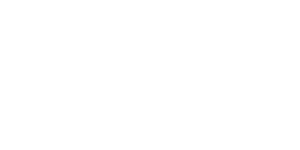

<IPython.core.display.Javascript object>


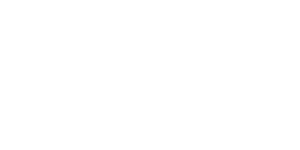

<IPython.core.display.Javascript object>


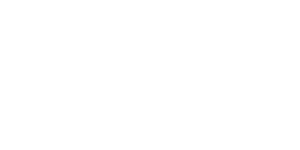

<IPython.core.display.Javascript object>


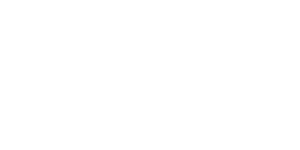

<IPython.core.display.Javascript object>


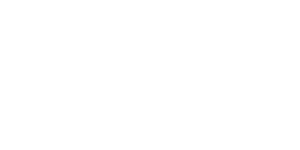

<IPython.core.display.Javascript object>


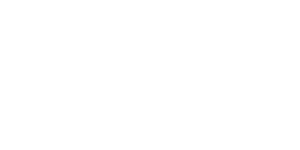

<IPython.core.display.Javascript object>


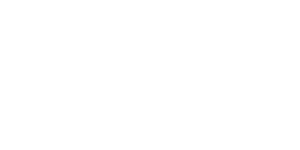

<IPython.core.display.Javascript object>


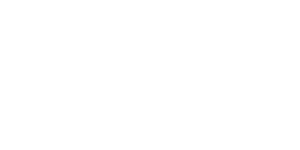

<IPython.core.display.Javascript object>


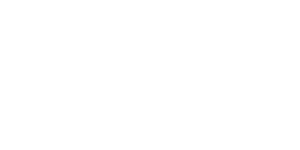

<IPython.core.display.Javascript object>


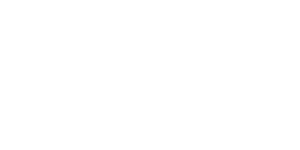

<IPython.core.display.Javascript object>


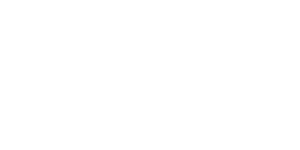

<IPython.core.display.Javascript object>


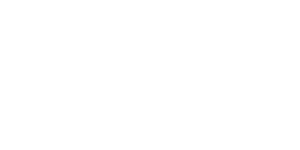

<IPython.core.display.Javascript object>


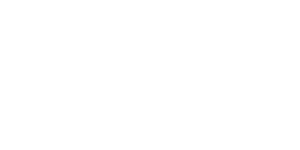

<IPython.core.display.Javascript object>


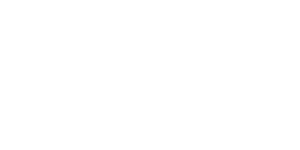

<IPython.core.display.Javascript object>


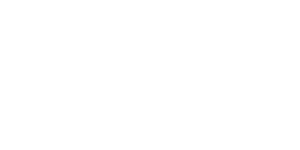

<IPython.core.display.Javascript object>


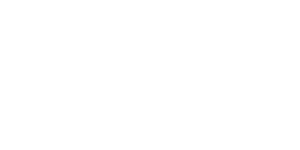

<IPython.core.display.Javascript object>


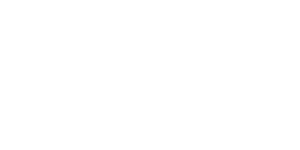

<IPython.core.display.Javascript object>


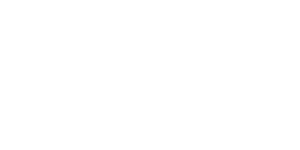

<IPython.core.display.Javascript object>


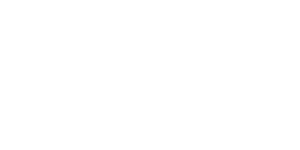

<IPython.core.display.Javascript object>


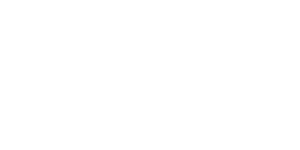

<IPython.core.display.Javascript object>


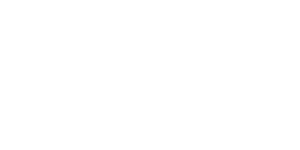

<IPython.core.display.Javascript object>


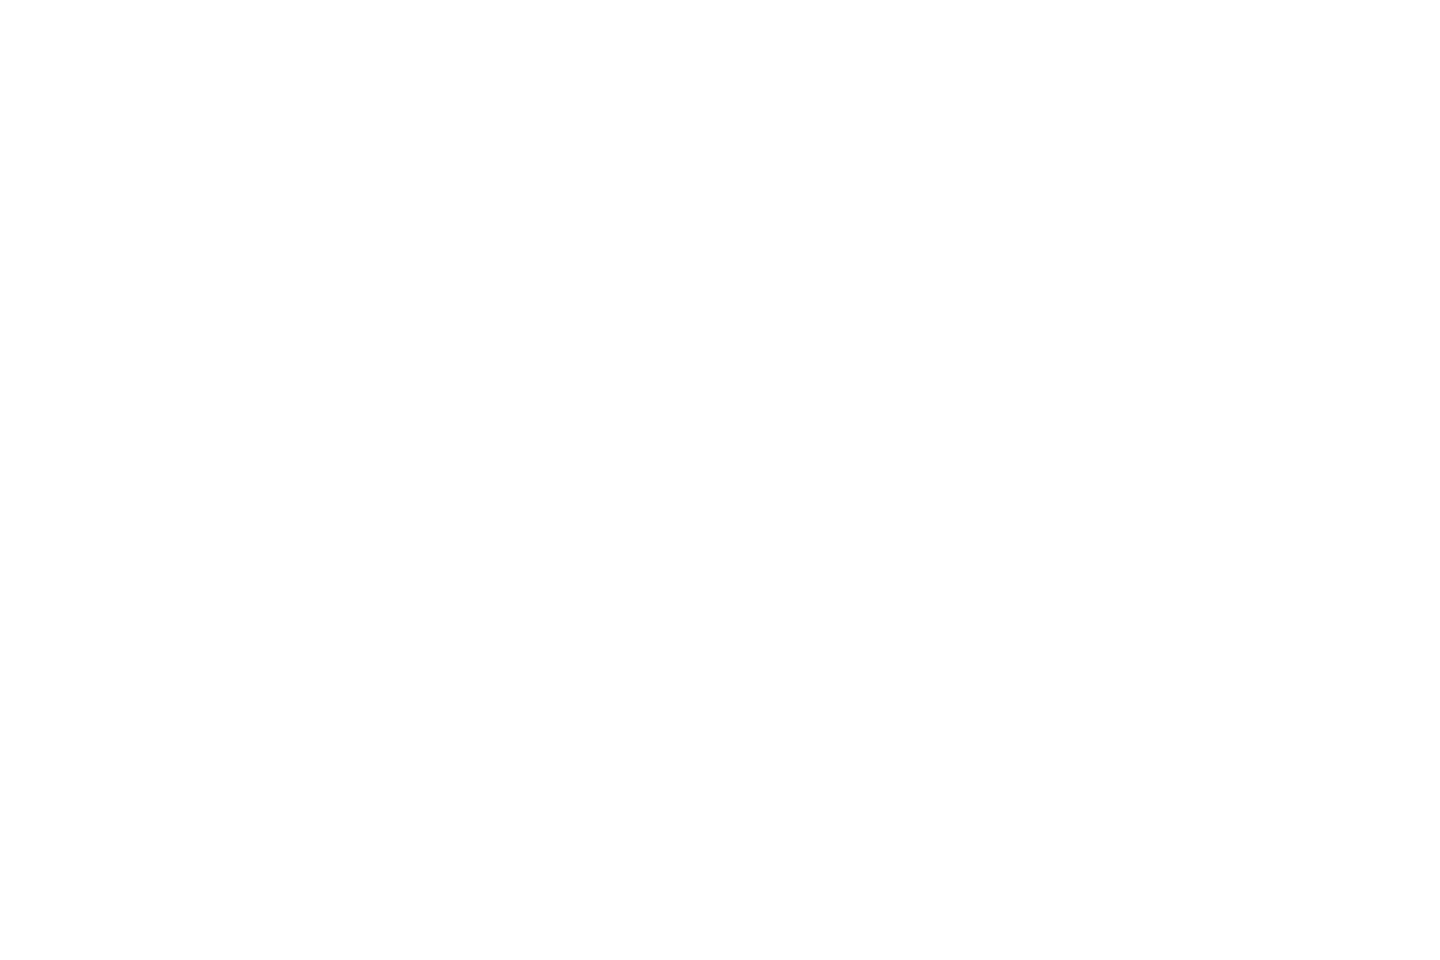

<IPython.core.display.Javascript object>


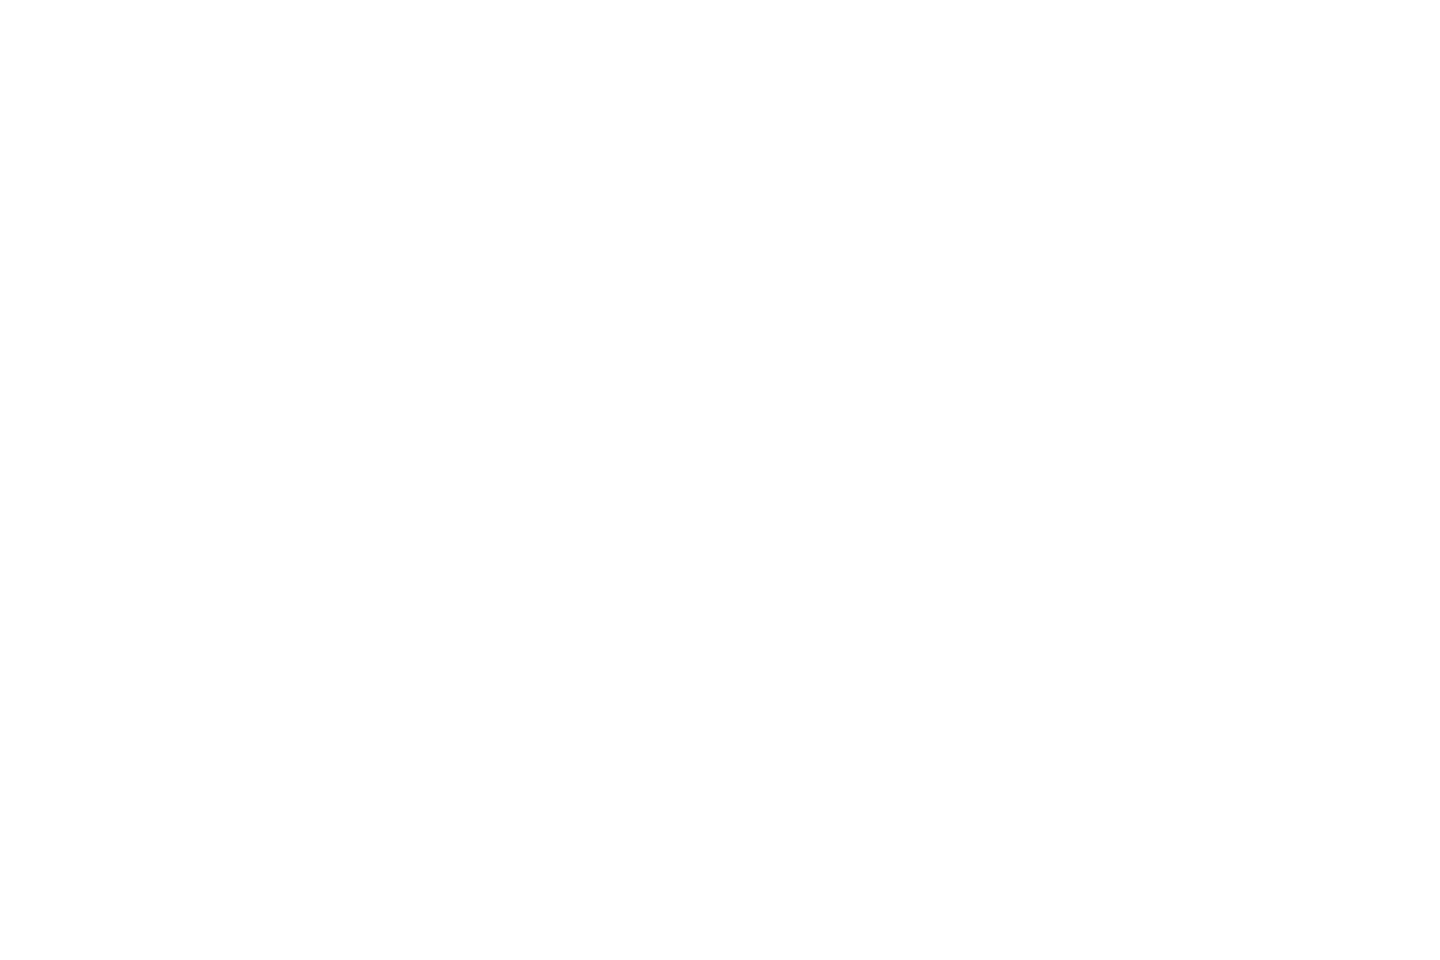

In [98]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

In [ ]:
######## OLD TFRS PRINTED BELOW!!


-4.039888709769912


<IPython.core.display.Javascript object>


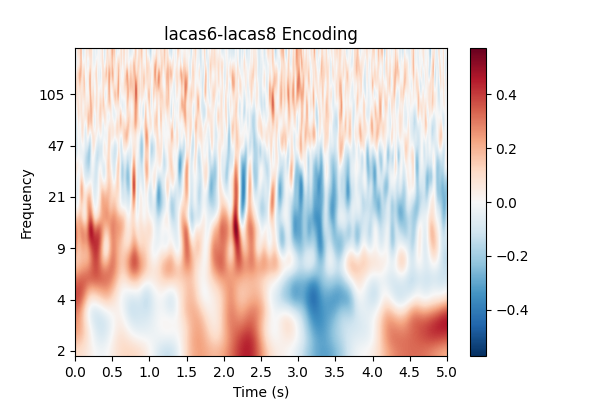

<IPython.core.display.Javascript object>


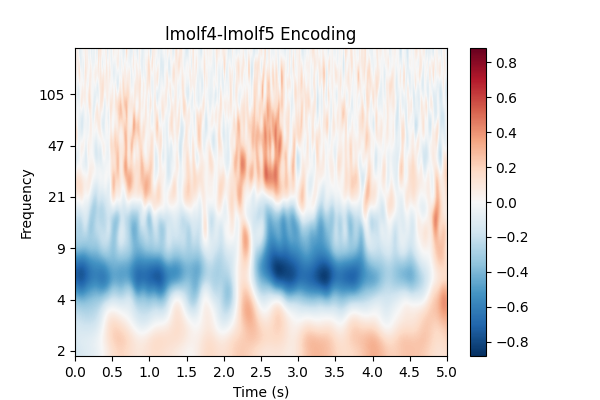

<IPython.core.display.Javascript object>


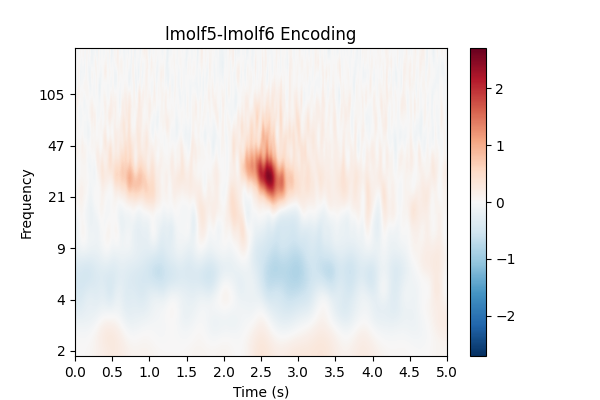

<IPython.core.display.Javascript object>


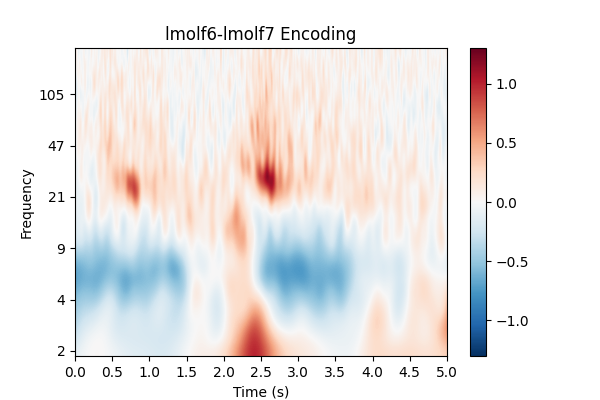

<IPython.core.display.Javascript object>


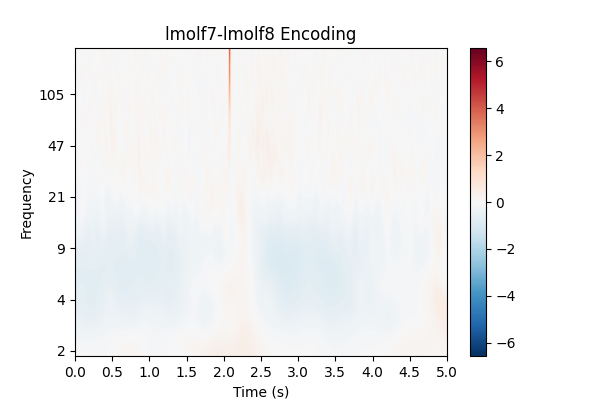

<IPython.core.display.Javascript object>


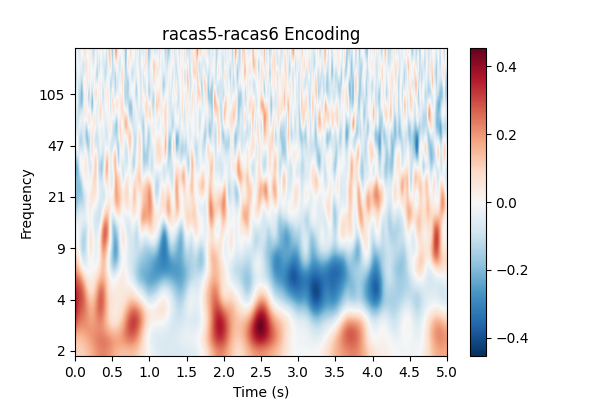

<IPython.core.display.Javascript object>


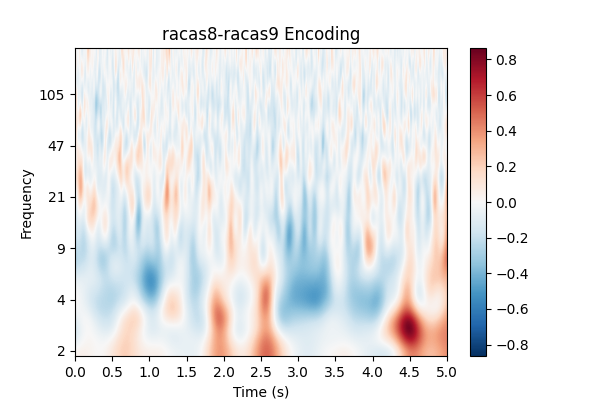

<IPython.core.display.Javascript object>


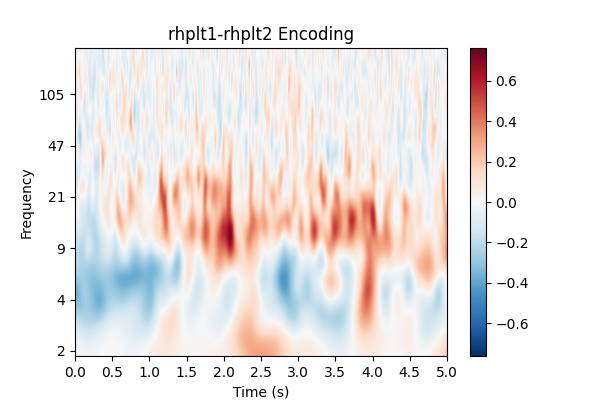

<IPython.core.display.Javascript object>


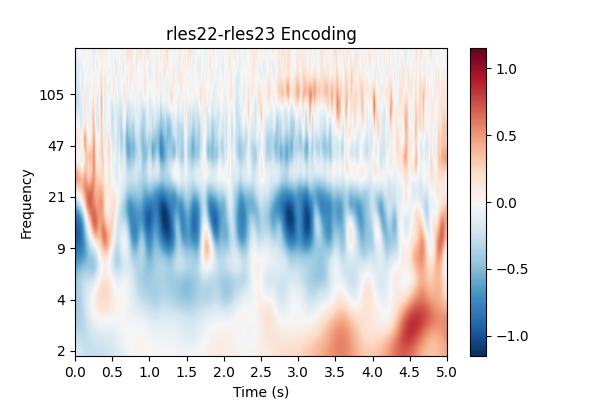

<IPython.core.display.Javascript object>


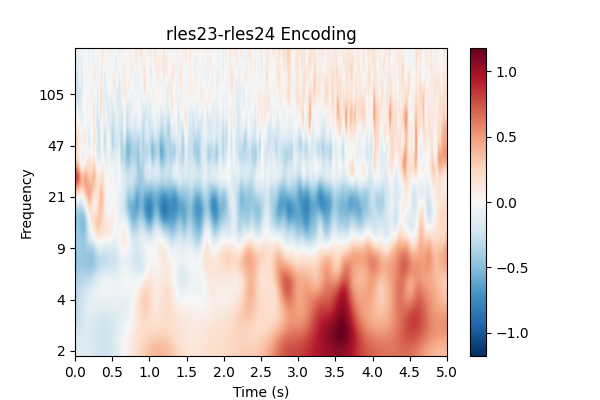

<IPython.core.display.Javascript object>


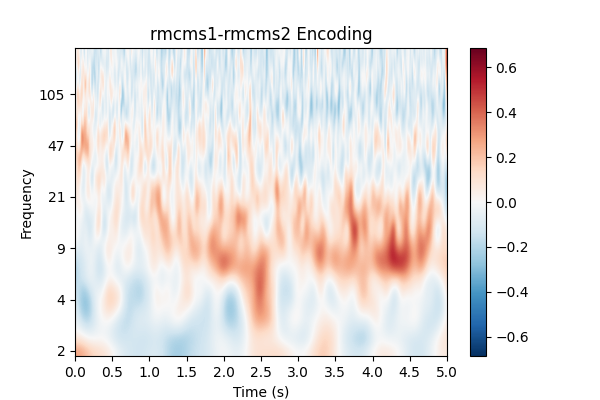

<IPython.core.display.Javascript object>


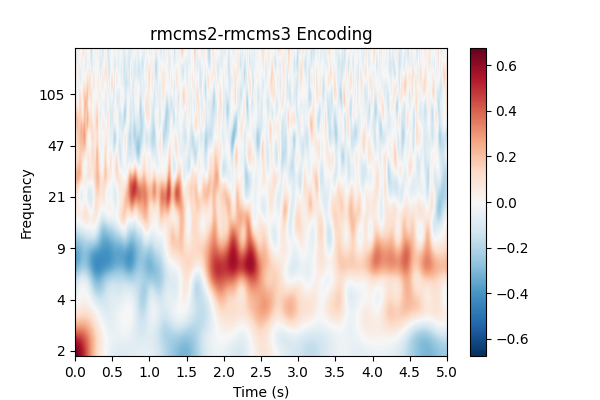

<IPython.core.display.Javascript object>


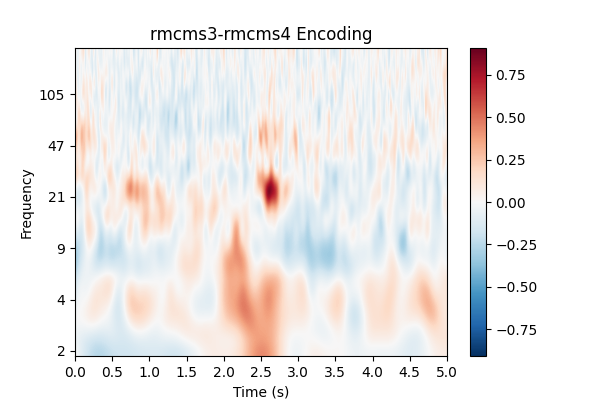

<IPython.core.display.Javascript object>


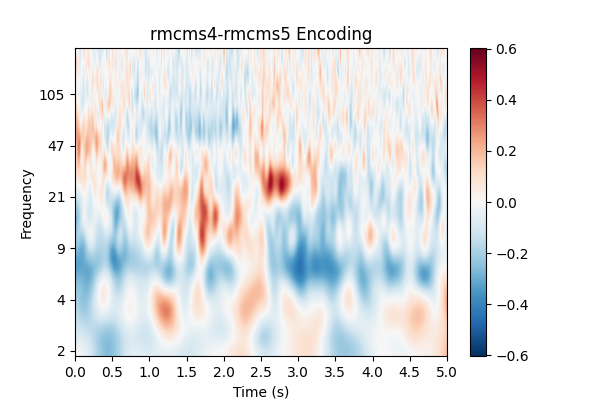

<IPython.core.display.Javascript object>


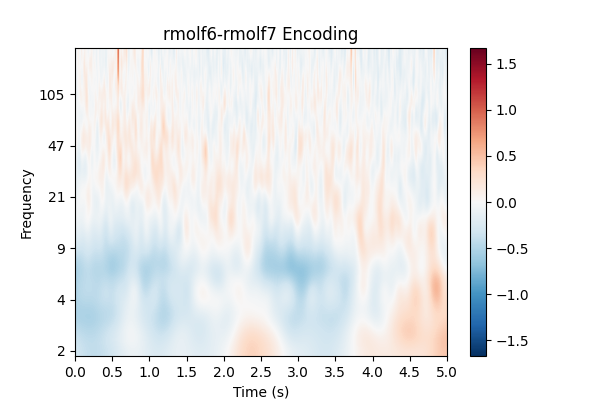

<IPython.core.display.Javascript object>


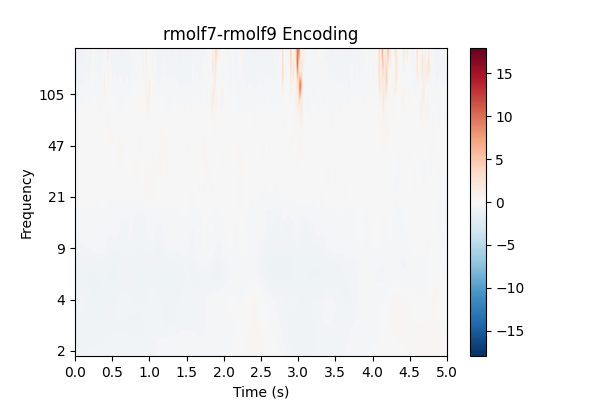

In [134]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
